# **<font color="darkblue">---- Reddit Gaming AI Talk — Thesis Analysis Notebook -----</font>**




# **Study Summary & Research Questions**

### **RQs**
- RQ1 (Volume/Salience): Which AI use cases dominate overall AI discussion in gaming?

- RQ2 (Engagement): Do engagement levels (score/comments) differ by AI use case (and by subreddit, as context)?

- RQ3 (Themes): What are the main topics/themes in the conversation? (BERTopic)

- RQ4 (Sentiment): What is the sentiment distribution overall and by AI use case, and how does sentiment relate to engagement?

- RQ5 (Genre): How does player perception of AI usage differ across game genres?

# Setup and Imports

In [1]:
!pip -q install bertopic sentence-transformers umap-learn hdbscan vaderSentiment scikit-learn
print("Packages installed.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 10.7 MB/s eta 0:00:00
Packages installed.


In [2]:
# ---------- Reproducibility ----------
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ---------- Core Data ----------
import pandas as pd

# ---------- Plotting (matplotlib only) ----------
import matplotlib.pyplot as plt

# ---------- Utilities ----------
from pathlib import Path

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 120)

print("Setup complete.")


Setup complete.


# **Load Dataset**

In [3]:
from pathlib import Path
import pandas as pd

path = "Cleaned_Reddit_Gaming.csv"
df = pd.read_csv(path, low_memory=False)

print("Shape:", df.shape)
df.head(2)

Shape: (299, 13)


,ai_use_case,game,subreddit,query_used,kind,post_id,score,num_comments,permalink,title,text,combined_text,created_dt
0,image_generation,Battlefield,gaming,"(""AI art"" OR ""AI-generated"" OR ""generative AI""...",post,1pt4ihv,19563.0,1248.0,https://www.reddit.com/r/gaming/comments/1pt4i...,Multi billion dollar company EA selling AI gen...,Not one person cared enough to correct it or e...,Multi billion dollar company EA selling AI gen...,2025-12-22 16:53:25+00:00
1,image_generation,Clair Obscur: Expedition 33,gaming,"(""AI art"" OR ""AI-generated"" OR ""generative AI""...",post,1prottw,7626.0,2040.0,https://www.reddit.com/r/gaming/comments/1prot...,Official Statement from the Indie Game Awards:...,Why were Clair Obscur: Expedition 33 and Chant...,Official Statement from the Indie Game Awards:...,2025-12-20 21:10:12+00:00


#**Data Validation and Quality Checks**

In [4]:
# ---------- Column overview ----------
print("Columns:", list(df.columns))
print("\nDtypes:\n", df.dtypes)

# ---------- Basic checks ----------
required = ["post_id", "ai_use_case", "kind", "subreddit"]
missing_required = [c for c in required if c not in df.columns]
if missing_required:
    raise ValueError(f"Missing required columns: {missing_required}")

# post_id uniqueness
n_total = len(df)
n_unique = df["post_id"].nunique(dropna=False)
print(f"\npost_id unique: {n_unique}/{n_total}")
if n_unique != n_total:
    print(" Warning: post_id is not fully unique. We'll handle duplicates in-memory if needed (no file edits).")

# kind distribution
print("\nkind value counts:")
print(df["kind"].value_counts(dropna=False))

# Missingness (top 15)
missing_pct = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
print("\nTop missing columns (%):")
display(missing_pct.head(15))

# Score/comment sanity checks if present
for col in ["score", "num_comments"]:
    if col in df.columns:
        print(f"\n{col} summary:")
        display(df[col].describe())
        if (df[col].dropna() < 0).any():
            print(f" Note: {col} contains negative values. We'll keep but report/handle carefully.")


Columns: ['ai_use_case', 'game', 'subreddit', 'query_used', 'kind', 'post_id', 'score', 'num_comments', 'permalink', 'title', 'text', 'combined_text', 'created_dt']

Dtypes:
 ai_use_case       object
game              object
subreddit         object
query_used        object
kind              object
post_id           object
score            float64
num_comments     float64
permalink         object
title             object
text              object
combined_text     object
created_dt        object
dtype: object

post_id unique: 299/299

kind value counts:
kind
post    299
Name: count, dtype: int64

Top missing columns (%):


,0
text,8.03
combined_text,0.33
created_dt,0.33
game,0.00
ai_use_case,0.00
kind,0.00
query_used,0.00
subreddit,0.00
post_id,0.00
permalink,0.00



score summary:


,score
count,299.000000
mean,692.595318
std,2676.655025
min,0.000000
25%,0.000000
50%,8.000000
75%,188.500000
max,31575.000000



num_comments summary:


,num_comments
count,299.000000
mean,155.478261
std,348.534143
min,0.000000
25%,9.000000
50%,31.000000
75%,111.500000
max,2563.000000


# **Create Analysis Variables**

In [5]:
df_analysis = df.copy()

# ---------- Final text selection (no file edits) ----------
text_candidates = [c for c in ["combined_text", "text", "title"] if c in df_analysis.columns]

if not text_candidates:
    raise ValueError("No text columns found among ['combined_text','text','title'].")

# Build final_text by priority: combined_text > text > title
df_analysis["final_text"] = None
for c in text_candidates:
    if df_analysis["final_text"].isna().all():
        df_analysis["final_text"] = df_analysis[c]
    else:
        df_analysis["final_text"] = df_analysis["final_text"].fillna(df_analysis[c])

# Clean minimal whitespace (safe, does not change original file)
df_analysis["final_text"] = (
    df_analysis["final_text"]
    .astype(str)
    .replace({"nan": np.nan, "None": np.nan})
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

#  drop rows with no text (for BERTopic + sentiment)
before = len(df_analysis)
df_analysis = df_analysis.dropna(subset=["final_text"]).copy()
print(f"Dropped {before - len(df_analysis)} rows with missing final_text. Remaining: {len(df_analysis)}")

# ---------- Engagement metric ----------
if "score" not in df_analysis.columns or "num_comments" not in df_analysis.columns:
    raise ValueError("Need 'score' and 'num_comments' columns for engagement analysis.")

df_analysis["score"] = pd.to_numeric(df_analysis["score"], errors="coerce")
df_analysis["num_comments"] = pd.to_numeric(df_analysis["num_comments"], errors="coerce")

df_analysis["engagement"] = df_analysis["score"].fillna(0) + 2 * df_analysis["num_comments"].fillna(0)
df_analysis["log_engagement"] = np.log1p(df_analysis["engagement"])

# ---------- Quick check ----------
display(df_analysis[["ai_use_case", "subreddit", "score", "num_comments", "engagement", "log_engagement"]].head(5))
print("\nengagement summary:")
display(df_analysis["engagement"].describe())


Dropped 0 rows with missing final_text. Remaining: 299


,ai_use_case,subreddit,score,num_comments,engagement,log_engagement
0,image_generation,gaming,19563.0,1248.0,22059.0,10.001521
1,image_generation,gaming,7626.0,2040.0,11706.0,9.367942
2,image_generation,gaming,4464.0,625.0,5714.0,8.650850
3,image_generation,gaming,0.0,151.0,302.0,5.713733
4,image_generation,gaming,7323.0,1236.0,9795.0,9.189729



engagement summary:


,engagement
count,299.000000
mean,1003.551839
std,3254.920767
min,0.000000
25%,24.000000
50%,80.000000
75%,444.500000
max,36409.000000


# **EDA 1 — Dataset Overview**

## **AI use case distribution**

,ai_use_case,count,percent
0,image_generation,178,59.53
1,gameplay_ai,106,35.45
2,moderation_ai,15,5.02


/tmp/ipython-input-3934149319.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


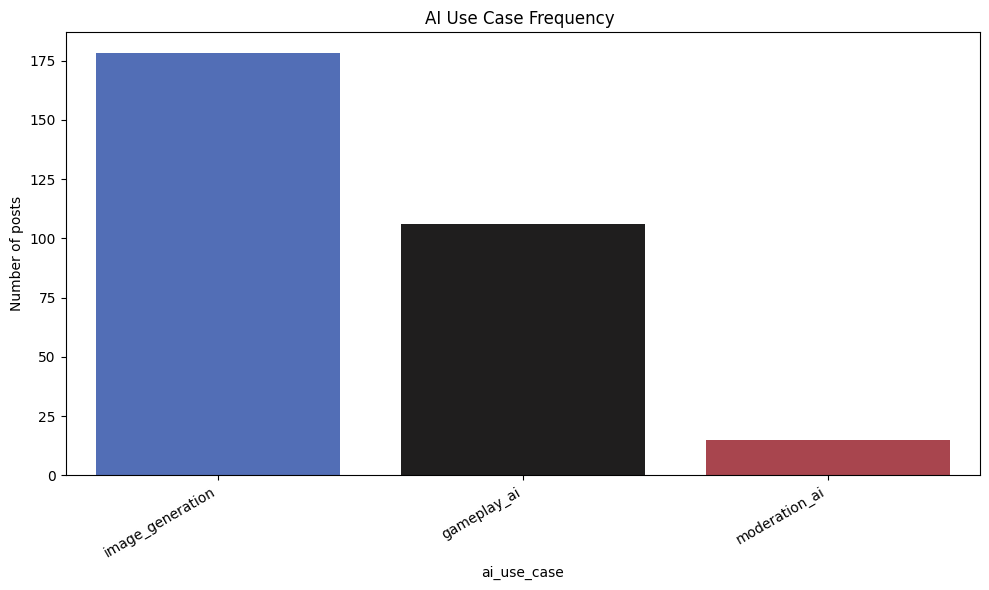

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- EDA 1A: AI use case distribution ---
usecase_counts = df_analysis["ai_use_case"].value_counts(dropna=False)
usecase_pct = (usecase_counts / len(df_analysis) * 100).round(2)

usecase_table = pd.DataFrame({
    "count": usecase_counts,
    "percent": usecase_pct
}).reset_index().rename(columns={"index": "ai_use_case"})

display(usecase_table)

# Bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=usecase_table,
    x="ai_use_case",
    y="count",
    palette="icefire"
)

plt.xticks(rotation=30, ha="right")
plt.ylabel("Number of posts")
plt.title("AI Use Case Frequency ")
plt.tight_layout()
plt.show()

## **AI Use Case × Subreddit**

In [7]:
# --- EDA 1C: Cross-tab: AI use case by top subreddits ---
top_subs = df_analysis["subreddit"].value_counts().head(10).index
df_topsubs = df_analysis[df_analysis["subreddit"].isin(top_subs)].copy()

crosstab = pd.crosstab(df_topsubs["ai_use_case"], df_topsubs["subreddit"])
display(crosstab)

#  row-normalized (%) so each use case sums to 100%
crosstab_pct = (crosstab.div(crosstab.sum(axis=1), axis=0) * 100).round(1)
display(crosstab_pct)


subreddit,CallOfDuty,Games,Warzone,gamedev,gaming,pcgaming,truegaming
ai_use_case,,,,,,,
gameplay_ai,8,20,5,31,20,12,10
image_generation,20,34,13,38,29,28,16
moderation_ai,1,0,1,9,4,0,0


subreddit,CallOfDuty,Games,Warzone,gamedev,gaming,pcgaming,truegaming
ai_use_case,,,,,,,
gameplay_ai,7.5,18.9,4.7,29.2,18.9,11.3,9.4
image_generation,11.2,19.1,7.3,21.3,16.3,15.7,9.0
moderation_ai,6.7,0.0,6.7,60.0,26.7,0.0,0.0


## **Top Subreddits**

,subreddit,count,percent
0,gamedev,78,26.09
1,Games,54,18.06
2,gaming,53,17.73
3,pcgaming,40,13.38
4,CallOfDuty,29,9.70
5,truegaming,26,8.70
6,Warzone,19,6.35


/tmp/ipython-input-1760579659.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


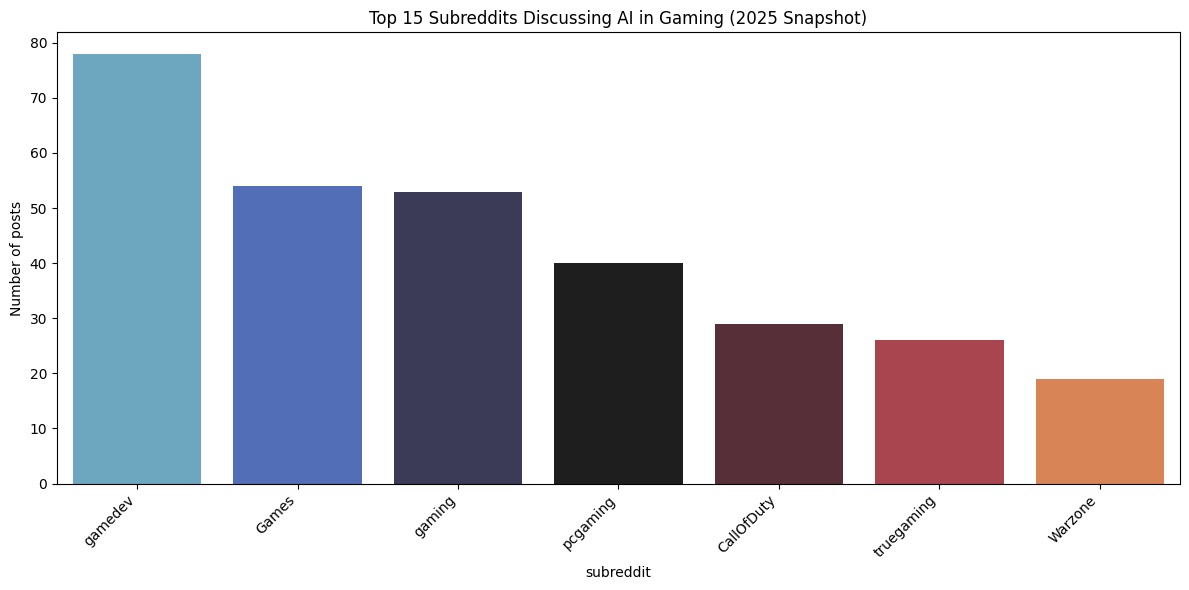

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- EDA 1B: Subreddit distribution ---
TOP_N = 15

sub_counts = df_analysis["subreddit"].value_counts().head(TOP_N)
sub_pct = (sub_counts / len(df_analysis) * 100).round(2)

sub_table = pd.DataFrame({
    "count": sub_counts,
    "percent": sub_pct
}).reset_index().rename(columns={"index": "subreddit"})

display(sub_table)

# Bar chart: Top subreddits
plt.figure(figsize=(12, 6))

# Applying the icefire palette via Seaborn
sns.barplot(
    data=sub_table,
    x="subreddit",
    y="count",
    palette="icefire"
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of posts")
plt.title(f"Top {TOP_N} Subreddits Discussing AI in Gaming (2025 Snapshot)")
plt.tight_layout()
plt.show()

In [9]:
if "created_dt" in df_analysis.columns:
    df_analysis["created_dt_parsed"] = pd.to_datetime(df_analysis["created_dt"], utc=True, errors="coerce")
    print(df_analysis["created_dt_parsed"].min(), "→", df_analysis["created_dt_parsed"].max())
    print("Missing created_dt_parsed:", df_analysis["created_dt_parsed"].isna().mean().round(4))


2024-12-23 07:17:33+00:00 → 2025-12-23 09:12:57+00:00
Missing created_dt_parsed: 0.0033


**Quick thesis-ready interpretation of what found (RQ1)**

AI talk is dominated by image generation (59.53%), followed by gameplay AI (35.45%), and moderation AI (5.02%).

The conversation is concentrated in developer + general gaming spaces:

r/gamedev (26.09%) is the largest single hub, then r/Games (18.06%) and r/gaming (17.73%).

The cross-tab shows a clear pattern:

moderation_ai is heavily concentrated in r/gamedev (60%), which makes sense (moderation tools & pipelines are often discussed in dev contexts).

image_generation is distributed across general and dev subs, showing it’s widely discussed beyond purely technical spaces.

# **EDA 2 — Engagement Distribution**

In [10]:
# --- EDA 2A: Summary stats for engagement variables ---
metrics = ["score", "num_comments", "engagement", "log_engagement"]
display(df_analysis[metrics].describe(percentiles=[.5, .75, .9, .95, .99]))

# Quick skew indicators using mean vs median
summary = pd.DataFrame({
    "mean": df_analysis[metrics].mean(),
    "median": df_analysis[metrics].median(),
    "std": df_analysis[metrics].std(),
})
summary["mean_minus_median"] = summary["mean"] - summary["median"]
display(summary)


,score,num_comments,engagement,log_engagement
count,299.000000,299.000000,299.000000,299.000000
mean,692.595318,155.478261,1003.551839,4.679044
std,2676.655025,348.534143,3254.920767,2.103432
min,0.000000,0.000000,0.000000,0.000000
50%,8.000000,31.000000,80.000000,4.394449
75%,188.500000,111.500000,444.500000,6.097288
90%,1335.400000,454.600000,2220.800000,7.705542
95%,3142.100000,725.000000,4394.500000,8.388288
99%,11544.120000,2047.420000,16664.040000,9.720457
max,31575.000000,2563.000000,36409.000000,10.502599


,mean,median,std,mean_minus_median
score,692.595318,8.000000,2676.655025,684.595318
num_comments,155.478261,31.000000,348.534143,124.478261
engagement,1003.551839,80.000000,3254.920767,923.551839
log_engagement,4.679044,4.394449,2.103432,0.284594


**Importance:**

- To visually confirm that raw engagement is skewed

- To confirm log_engagement is more “normal-like” and better for comparisons

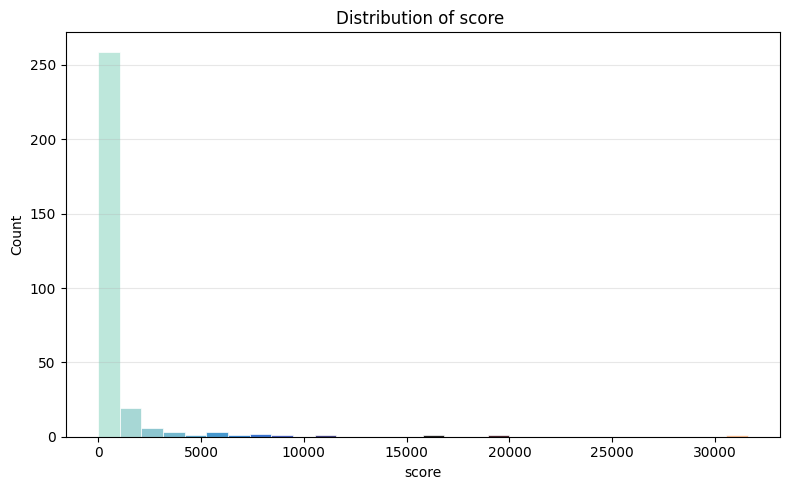

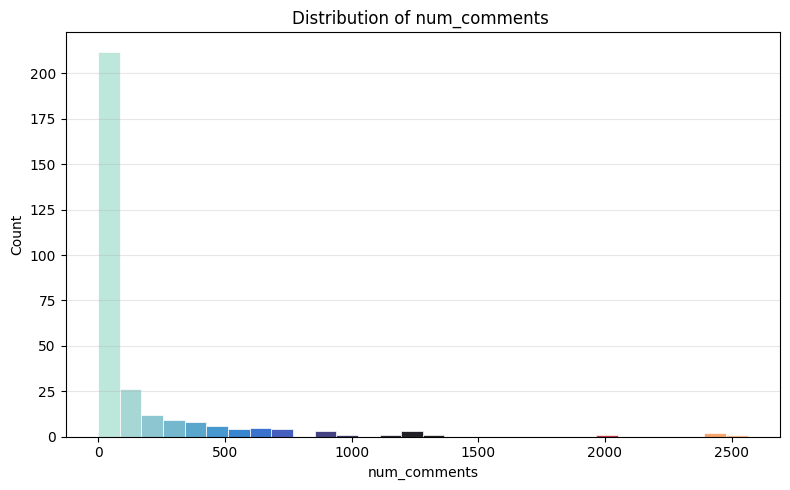

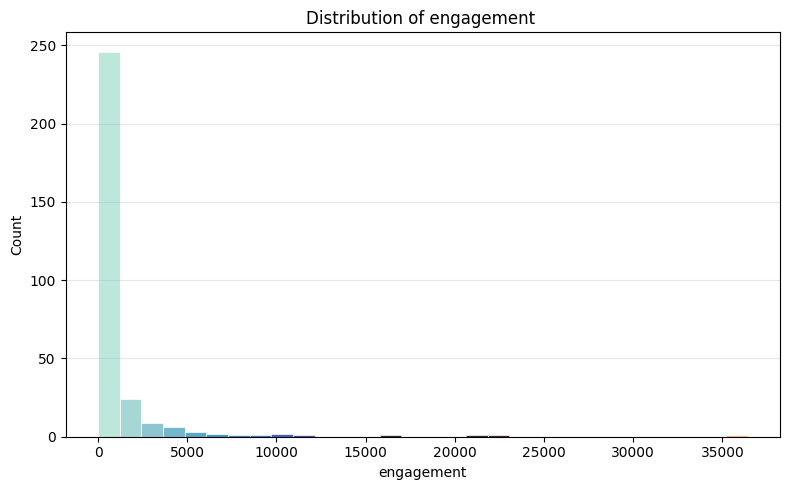

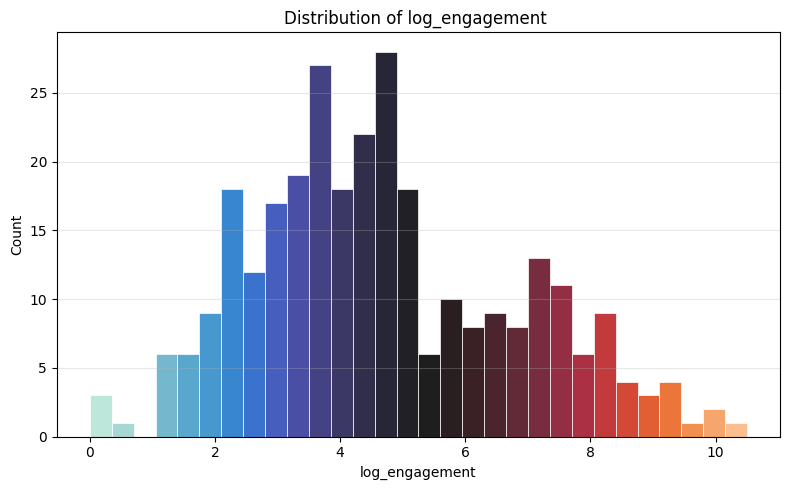

In [11]:
# Create the colormap object
cmap = sns.color_palette("icefire", as_cmap=True)

# --- EDA 2B: Histograms (raw + log) with Cubehelix Gradient ---
for col in ["score", "num_comments", "engagement", "log_engagement"]:
    plt.figure(figsize=(8, 5))

    # We grab 'patches' to color them individually
    n, bins, patches = plt.hist(df_analysis[col].dropna(), bins=30, edgecolor='white', linewidth=0.5)

    # Apply the gradient: color each patch (bar) based on its index
    for i, patch in enumerate(patches):
        plt.setp(patch, 'facecolor', cmap(i / len(patches)))

    plt.title(f"Distribution of {col} ")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(axis='y', alpha=0.3) # Adds a light grid for readability
    plt.tight_layout()
    plt.show()

In [12]:
# --- EDA 2C: Top 10 posts by engagement (outlier context) ---
top10 = df_analysis.sort_values("engagement", ascending=False).head(10)
display(top10[["ai_use_case", "subreddit", "score", "num_comments", "engagement", "permalink", "title"]])


,ai_use_case,subreddit,score,num_comments,engagement,permalink,title
14,image_generation,gaming,31575.0,2417.0,36409.0,https://www.reddit.com/r/gaming/comments/1owxn...,Call of Duty: Black Ops 7 is littered with AI ...
0,image_generation,gaming,19563.0,1248.0,22059.0,https://www.reddit.com/r/gaming/comments/1pt4i...,Multi billion dollar company EA selling AI gen...
23,image_generation,gaming,16254.0,2411.0,21076.0,https://www.reddit.com/r/gaming/comments/1pobz...,Larian Studios CEO Swen Vincke responds to Gen...
287,moderation_ai,gaming,11448.0,2563.0,16574.0,https://www.reddit.com/r/gaming/comments/1ihrx...,Games that 'cheated' to feel more fun
1,image_generation,gaming,7626.0,2040.0,11706.0,https://www.reddit.com/r/gaming/comments/1prot...,Official Statement from the Indie Game Awards:...
5,image_generation,gaming,7575.0,1185.0,9945.0,https://www.reddit.com/r/gaming/comments/1po3z...,"Divinity is confirmed to be turn based, planni..."
4,image_generation,gaming,7323.0,1236.0,9795.0,https://www.reddit.com/r/gaming/comments/1pp47...,"""We would rather cut off our own arms"": Indie ..."
6,image_generation,gaming,8547.0,457.0,9461.0,https://www.reddit.com/r/gaming/comments/1pat0...,"Fortnite fans are saying ""no to AI slop"" after..."
170,image_generation,truegaming,6182.0,550.0,7282.0,https://www.reddit.com/r/truegaming/comments/1...,Watching my casual gamer friend play made me r...
97,image_generation,CallOfDuty,5356.0,743.0,6842.0,https://www.reddit.com/r/CallOfDuty/comments/1...,[COD] Call of Duty is caught using A.I. in a f...


## **RQ2 statistical testing (Kruskal–Wallis + Dunn post-hoc)**

**Imporatnce:**

- To answer "Do different AI use cases have different engagement distributions?"

Kruskal–Wallis + effect size (epsilon-squared)

In [13]:
from scipy.stats import kruskal

groups = []
labels = []
for use_case, g in df_analysis.groupby("ai_use_case"):
    vals = g["log_engagement"].dropna().values
    if len(vals) > 0:
        groups.append(vals)
        labels.append(use_case)

H, p = kruskal(*groups)

n = len(df_analysis)
k = len(groups)

# Epsilon-squared effect size for Kruskal–Wallis
# eps^2 = (H - k + 1) / (n - k)
eps2 = (H - k + 1) / (n - k)

print("Kruskal–Wallis on log_engagement by ai_use_case")
print("H =", float(H))
print("p-value =", float(p))
print("epsilon-squared (effect size) =", float(eps2))
print("Groups:", labels)


Kruskal–Wallis on log_engagement by ai_use_case
H = 4.454381019089431
p-value = 0.10783095500530819
epsilon-squared (effect size) = 0.008291827767194023
Groups: ['gameplay_ai', 'image_generation', 'moderation_ai']


Data suggests that the type of AI use case does not significantly impact engagement levels. Whether a post/interaction involved gameplay_ai, image_generation, or moderation_ai, the resulting engagement (on a logarithmic scale) remained statistically similar

Dunn post-hoc (pairwise) with correction - to find which specific groups differ

In [14]:
!pip -q install scikit-posthocs
import scikit_posthocs as sp

dunn = sp.posthoc_dunn(
    df_analysis,
    val_col="log_engagement",
    group_col="ai_use_case",
    p_adjust="holm"
)

display(dunn)


,gameplay_ai,image_generation,moderation_ai
gameplay_ai,1.000000,0.141069,0.430452
image_generation,0.141069,1.000000,0.714878
moderation_ai,0.430452,0.714878,1.000000


Visual: engagement by use case (log scale)

/tmp/ipython-input-3784663905.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order)


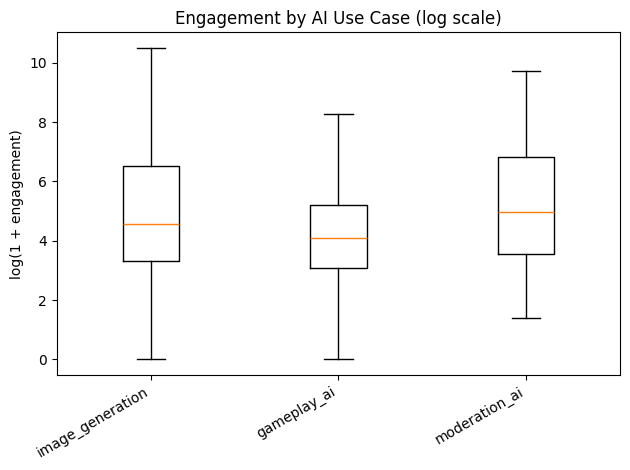

In [15]:
# Boxplot (matplotlib)
order = df_analysis["ai_use_case"].value_counts().index

data = [df_analysis.loc[df_analysis["ai_use_case"] == uc, "log_engagement"].dropna() for uc in order]

plt.figure()
plt.boxplot(data, labels=order)
plt.xticks(rotation=30, ha="right")
plt.ylabel("log(1 + engagement)")  # the data is high skewed
plt.title("Engagement by AI Use Case (log scale)")
plt.tight_layout()
plt.show()


**Engagment remains consistent regardless of the AI use case.**

# **Sentiment Analysis (VADER)**

In [16]:
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# 1. Cleaning function
def minimal_clean_for_vader(text: str) -> str:
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text[:8000]

# 2. Prepare text
df_analysis["text_for_sentiment"] = df_analysis["final_text"].apply(minimal_clean_for_vader)

# 3. Compute VADER scores
scores = df_analysis["text_for_sentiment"].apply(lambda t: analyzer.polarity_scores(t))
scores_df = pd.DataFrame(list(scores))

# --- FIX START: Remove old sentiment columns if they exist to avoid duplicates ---
cols_to_drop = ['neg', 'neu', 'pos', 'compound', 'sentiment_label']
df_analysis = df_analysis.drop(columns=[c for c in cols_to_drop if c in df_analysis.columns])
# --- FIX END ---

# 4. Combine scores with the main dataframe
df_analysis = pd.concat([df_analysis.reset_index(drop=True), scores_df.reset_index(drop=True)], axis=1)

# 5. Label sentiment
def label_sentiment(compound_val):
    # We ensure we are comparing a single float value
    if compound_val >= 0.05:
        return "positive"
    elif compound_val <= -0.05:
        return "negative"
    else:
        return "neutral"

df_analysis["sentiment_label"] = df_analysis["compound"].apply(label_sentiment)

# 6. Display Configuration
pd.set_option('display.max_colwidth', 500)

# Show the results including combined_text
display(df_analysis[["combined_text", "ai_use_case", "subreddit", "compound", "sentiment_label"]].head(10))

# Print distribution
print("\nSentiment Distribution:")
print(df_analysis["sentiment_label"].value_counts(normalize=True).round(3))

,combined_text,ai_use_case,subreddit,compound,sentiment_label
0,Multi billion dollar company EA selling AI generated slop in their store (Battlefield 6) Not one person cared enough to correct it or even notice it in the first place.,image_generation,gaming,-0.6036,negative
1,"Official Statement from the Indie Game Awards: 'Clair Obscur: Expedition 33' and 'Chantey's' awards retracted and awarded instead to 'Sorry We’re Closed' and 'Blue Prince' due to GenAI usage Why were Clair Obscur: Expedition 33 and Chantey's awards retracted? The Indie Game Awards have a hard stance on the use of gen AI throughout the nomination process and during the ceremony itself. When it was submitted for consideration, representatives of Sandfall Interactive agreed that no gen AI was u...",image_generation,gaming,0.9959,positive
2,Concept Artists Say Generative AI References Only Make Their Jobs Harder,image_generation,gaming,0.0000,neutral
3,"Do gamers care if generative AI is used when coding games? Most of the discussion around AI use in gaming is focused on art and voice genAI. It’s currently pretty easy to spot these uses, and they tend to impact the quality of the final product a lot. But using AI for coding is becoming extremely common. GenAI features are now available in almost all coding tools and basic usage tiers are free. As a player, there’s no way to know if a game used gen AI for code. Bad code is possible and even ...",image_generation,gaming,0.8673,positive
4,"""We would rather cut off our own arms"": Indie devs react to Arc Raiders CEO saying people should assume everyone's using generative AI these days",image_generation,gaming,-0.2732,negative
5,"Divinity is confirmed to be turn based, planning to do early access again and Swen comments on Larian's use of AI- Bloomberg >Vincke said Larian plans to do an early-access release of *Divinity*, as the company has with previous games, although it's unlikely to be out in 2026. He wouldn't offer many specifics about the new game other than to say it will continue to iterate on the studio's previous work. >""This is going to be us unleashed, I think,"" Vincke said. ""It's a turn-based RPG featuri...",image_generation,gaming,0.9621,positive
6,"Fortnite fans are saying ""no to AI slop"" after spotting what they believe are AI-generated images in-game",image_generation,gaming,0.0000,neutral
7,PS5 Roguelike Let It Die: Inferno Uses a Crapload of Generative AI,image_generation,gaming,-0.5994,negative
8,"With so many games including AI-generated images, keep your ears open for AI-generated music It just occurred to me that if studios are not ashamed to use AI for game assets like images, dialog or stoey scripts, even coding, they probably do the same with music and sounds.",image_generation,gaming,0.6960,positive
9,"So, seeing how Black Ops 7 isn't doing so well, I actually want to shine a light on a few aspects of said failure that have been barelly brought up. So, the generative AI usage and the nonsensical mess of a campaign absolutely have an effect on the overall perception and reception of the game (and also suck on a general level), it will absolute cost them sales but there's even bigger reasons for why it's performing so poorly (at least on Steam) that I'm seeing basically no one talk about. Fi...",image_generation,gaming,-0.8746,negative



Sentiment Distribution:
sentiment_label
positive    0.686
negative    0.271
neutral     0.043
Name: proportion, dtype: float64


In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import pandas as pd # Ensure pandas is imported

analyzer = SentimentIntensityAnalyzer()

def minimal_clean_for_vader(text: str) -> str:
    if pd.isna(text):
        return ""
    text = str(text)
    # remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)
    # normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    # safety: avoid extremely long strings
    return text[:8000]

df_analysis["text_for_sentiment"] = df_analysis["final_text"].apply(minimal_clean_for_vader)

# Compute VADER scores
scores = df_analysis["text_for_sentiment"].apply(lambda t: analyzer.polarity_scores(t))
scores_df = pd.DataFrame(list(scores))

# Define sentiment column names to be added/updated
sentiment_cols_to_add = ['neg', 'neu', 'pos', 'compound']

# Drop existing sentiment columns from df_analysis to ensure clean replacement
# Use errors='ignore' so it doesn't fail if a column doesn't exist
df_analysis = df_analysis.drop(columns=sentiment_cols_to_add, errors='ignore')

# Add the newly computed sentiment columns by concatenating with alignment
df_analysis = pd.concat([df_analysis, scores_df[sentiment_cols_to_add]], axis=1)

# Ensure the 'compound' column is explicitly numeric before applying the function
df_analysis["compound"] = pd.to_numeric(df_analysis["compound"], errors='coerce')

# Label sentiment using standard VADER thresholds
def label_sentiment(compound: float) -> str:
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

df_analysis["sentiment_label"] = df_analysis["compound"].apply(label_sentiment)

display(df_analysis[["ai_use_case", "subreddit", "combined_text", "compound", "sentiment_label"]].head(50))
print(df_analysis["sentiment_label"].value_counts(normalize=True).round(3))


,ai_use_case,subreddit,combined_text,compound,sentiment_label
0,image_generation,gaming,Multi billion dollar company EA selling AI generated slop in their store (Battlefield 6) Not one person cared enough to correct it or even notice it in the first place.,-0.6036,negative
1,image_generation,gaming,"Official Statement from the Indie Game Awards: 'Clair Obscur: Expedition 33' and 'Chantey's' awards retracted and awarded instead to 'Sorry We’re Closed' and 'Blue Prince' due to GenAI usage Why were Clair Obscur: Expedition 33 and Chantey's awards retracted? The Indie Game Awards have a hard stance on the use of gen AI throughout the nomination process and during the ceremony itself. When it was submitted for consideration, representatives of Sandfall Interactive agreed that no gen AI was u...",0.9959,positive
2,image_generation,gaming,Concept Artists Say Generative AI References Only Make Their Jobs Harder,0.0000,neutral
3,image_generation,gaming,"Do gamers care if generative AI is used when coding games? Most of the discussion around AI use in gaming is focused on art and voice genAI. It’s currently pretty easy to spot these uses, and they tend to impact the quality of the final product a lot. But using AI for coding is becoming extremely common. GenAI features are now available in almost all coding tools and basic usage tiers are free. As a player, there’s no way to know if a game used gen AI for code. Bad code is possible and even ...",0.8673,positive
4,image_generation,gaming,"""We would rather cut off our own arms"": Indie devs react to Arc Raiders CEO saying people should assume everyone's using generative AI these days",-0.2732,negative
5,image_generation,gaming,"Divinity is confirmed to be turn based, planning to do early access again and Swen comments on Larian's use of AI- Bloomberg >Vincke said Larian plans to do an early-access release of *Divinity*, as the company has with previous games, although it's unlikely to be out in 2026. He wouldn't offer many specifics about the new game other than to say it will continue to iterate on the studio's previous work. >""This is going to be us unleashed, I think,"" Vincke said. ""It's a turn-based RPG featuri...",0.9621,positive
6,image_generation,gaming,"Fortnite fans are saying ""no to AI slop"" after spotting what they believe are AI-generated images in-game",0.0000,neutral
7,image_generation,gaming,PS5 Roguelike Let It Die: Inferno Uses a Crapload of Generative AI,-0.5994,negative
8,image_generation,gaming,"With so many games including AI-generated images, keep your ears open for AI-generated music It just occurred to me that if studios are not ashamed to use AI for game assets like images, dialog or stoey scripts, even coding, they probably do the same with music and sounds.",0.6960,positive
9,image_generation,gaming,"So, seeing how Black Ops 7 isn't doing so well, I actually want to shine a light on a few aspects of said failure that have been barelly brought up. So, the generative AI usage and the nonsensical mess of a campaign absolutely have an effect on the overall perception and reception of the game (and also suck on a general level), it will absolute cost them sales but there's even bigger reasons for why it's performing so poorly (at least on Steam) that I'm seeing basically no one talk about. Fi...",-0.8746,negative


sentiment_label
positive    0.686
negative    0.271
neutral     0.043
Name: proportion, dtype: float64


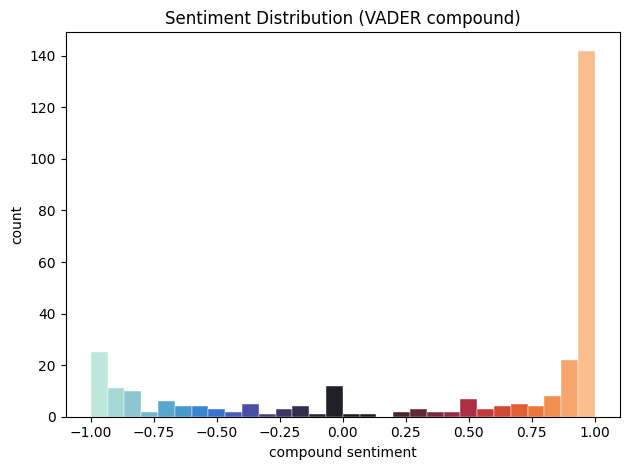

,compound
count,299.000000
mean,0.417209
std,0.752651
min,-0.999300
25%,-0.229750
50%,0.923900
75%,0.992500
90%,0.998920
95%,0.999600
99%,0.999802


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the palette
cmap = sns.color_palette("icefire", as_cmap=True)

plt.figure()
# Capture 'patches' to apply the color palette
n, bins, patches = plt.hist(df_analysis["compound"].dropna(), bins=30, edgecolor='white', linewidth=0.3)

# Apply the gradient across the bins
for i, patch in enumerate(patches):
    plt.setp(patch, 'facecolor', cmap(i / len(patches)))

plt.title("Sentiment Distribution (VADER compound)")
plt.xlabel("compound sentiment")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Summary stats
display(df_analysis["compound"].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

sentiment_label,negative,neutral,positive
ai_use_case,,,
gameplay_ai,0.396,0.009,0.594
image_generation,0.202,0.067,0.730
moderation_ai,0.200,0.000,0.800


/tmp/ipython-input-2585487052.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order)


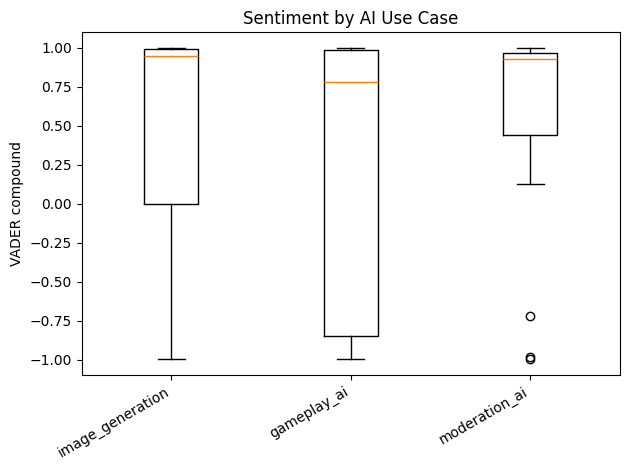

In [19]:
# Table: sentiment label proportions by ai_use_case
sent_table = pd.crosstab(df_analysis["ai_use_case"], df_analysis["sentiment_label"], normalize="index").round(3)
display(sent_table)

# Boxplot: compound by ai_use_case
order = df_analysis["ai_use_case"].value_counts().index
data = [df_analysis.loc[df_analysis["ai_use_case"] == uc, "compound"].dropna() for uc in order]

plt.figure()
plt.boxplot(data, labels=order)
plt.xticks(rotation=30, ha="right")
plt.ylabel("VADER compound")
plt.title("Sentiment by AI Use Case")
plt.tight_layout()
plt.show()


In [20]:
from scipy.stats import kruskal

groups = []
labels = []
for use_case, g in df_analysis.groupby("ai_use_case"):
    vals = g["compound"].dropna().values
    if len(vals) > 0:
        groups.append(vals)
        labels.append(use_case)

H, p = kruskal(*groups)

n = len(df_analysis)
k = len(groups)
eps2 = (H - k + 1) / (n - k)  # epsilon-squared

print("Kruskal–Wallis on VADER compound by ai_use_case")
print("H =", float(H))
print("p-value =", float(p))
print("epsilon-squared =", float(eps2))
print("Groups:", labels)


Kruskal–Wallis on VADER compound by ai_use_case
H = 6.121429508049236
p-value = 0.04685419402510813
epsilon-squared = 0.013923748338004175
Groups: ['gameplay_ai', 'image_generation', 'moderation_ai']


Does sentiment differ by AI use case?

Yes, there is a statistically significant difference in the sentiment (VADER compound score) across the three AI use cases.

## **Sentiment vs engagement**

Spearman correlation: sentiment (compound) vs log_engagement
rho = 0.05510169563298466
p-value = 0.3423521306838182


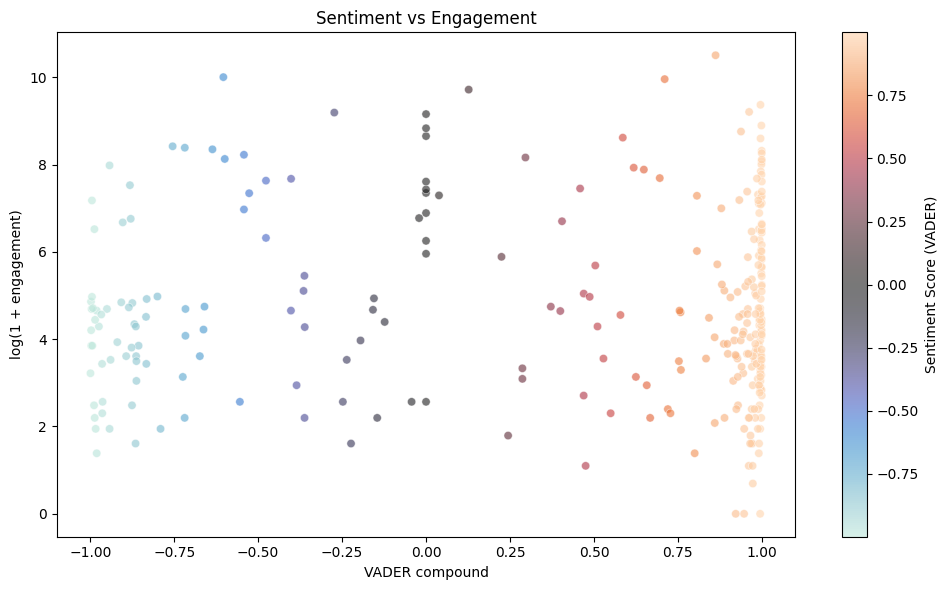

In [21]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Initialize the palette as a colormap
cmap = sns.color_palette("icefire", as_cmap=True)

rho, p = spearmanr(df_analysis["compound"], df_analysis["log_engagement"], nan_policy="omit")
print("Spearman correlation: sentiment (compound) vs log_engagement")
print("rho =", float(rho))
print("p-value =", float(p))

# Scatter with Cubehelix palette
plt.figure(figsize=(10, 6))

# 2. Use 'c' to map the color to the sentiment score and 'cmap' to apply the palette
scatter = plt.scatter(
    df_analysis["compound"],
    df_analysis["log_engagement"],
    c=df_analysis["compound"],      # Color points based on sentiment
    cmap=cmap,                      # Apply the cubehelix palette
    alpha=0.6,                      # Add transparency for overplotting
    edgecolors='w',                 # White edges help distinguish overlapping points
    linewidth=0.5
)

# 3. Add a colorbar to show the sentiment scale
plt.colorbar(scatter, label="Sentiment Score (VADER)")

plt.title("Sentiment vs Engagement")
plt.xlabel("VADER compound")
plt.ylabel("log(1 + engagement)")
plt.tight_layout()
plt.show()

## **Regression check**

In [22]:
!pip -q install statsmodels
import statsmodels.formula.api as smf

# OLS with robust standard errors
model = smf.ols("log_engagement ~ compound + C(ai_use_case)", data=df_analysis).fit(cov_type="HC3")
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         log_engagement   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.081
Date:                Thu, 08 Jan 2026   Prob (F-statistic):              0.103
Time:                        17:19:29   Log-Likelihood:                -642.90
No. Observations:                 299   AIC:                             1294.
Df Residuals:                     295   BIC:                             1309.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

# **BERTopic (RQ3)**

In [23]:
!pip -q install bertopic sentence-transformers umap-learn hdbscan scikit-learn
print("Installed BERTopic stack.")


Installed BERTopic stack.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer

# Safety checks: make sure earlier steps exist
assert "df_analysis" in globals(), "df_analysis not found. Run earlier steps (load + variables + sentiment) first."
assert "final_text" in df_analysis.columns, "final_text missing in df_analysis."
assert "sentiment_label" in df_analysis.columns, "sentiment_label missing. Run VADER section first."

# Seed
if "SEED" not in globals():
    SEED = 42

print("BERTopic imports OK. SEED =", SEED)


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


BERTopic imports OK. SEED = 42


In [25]:
def minimal_clean_for_topic(text: str) -> str:
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r"http\S+|www\.\S+", "", text)     # remove URLs
    text = re.sub(r"[\r\n\t]+", " ", text)          # normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_topic2 = df_analysis.copy()
df_topic2["text_for_topic"] = df_topic2["final_text"].apply(minimal_clean_for_topic)

# Remove very short texts (Short texts often become noise and increase outliers/unclustered docs in BERTopic.)
MIN_CHARS = 30
before = len(df_topic2)
df_topic2 = df_topic2[df_topic2["text_for_topic"].str.len() >= MIN_CHARS].copy()
print(f"Kept {len(df_topic2)}/{before} docs after removing texts < {MIN_CHARS} chars.")

docs = df_topic2["text_for_topic"].tolist()
docs[0][:250]


Kept 299/299 docs after removing texts < 30 chars.


'Multi billion dollar company EA selling AI generated slop in their store (Battlefield 6) Not one person cared enough to correct it or even notice it in the first place.'

In [26]:
# Vectorizer improves topic keywords a lot (removes stopwords, includes bigrams)
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2
)

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=SEED
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

topic_model2 = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

print("Model ready.")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model ready.


In [27]:
topics2, probs2 = topic_model2.fit_transform(docs)
df_topic2["topic_id"] = topics2

print("Fitted.")
print("Unique topics (incl -1):", pd.Series(topics2).nunique())
print("Outliers (-1):", int((df_topic2["topic_id"] == -1).sum()))


2026-01-08 17:20:44,344 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2026-01-08 17:21:27,595 - BERTopic - Embedding - Completed ✓
2026-01-08 17:21:27,596 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-08 17:21:36,777 - BERTopic - Dimensionality - Completed ✓
2026-01-08 17:21:36,778 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-08 17:21:36,803 - BERTopic - Cluster - Completed ✓
2026-01-08 17:21:36,809 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-08 17:21:37,149 - BERTopic - Representation - Completed ✓


Fitted.
Unique topics (incl -1): 8
Outliers (-1): 69


In [28]:
topic_info2 = topic_model2.get_topic_info()
display(topic_info2.head(15))

outliers = int((df_topic2["topic_id"] == -1).sum())
print("Docs used:", len(df_topic2))
print("Outlier %:", round(outliers / len(df_topic2) * 100, 1))


,Topic,Count,Name,Representation,Representative_Docs
0,-1,69,-1_game_like_just_games,"[game, like, just, games, players, ai, player, play, ve, want]","[Three strands of thought on Death Stranding 2 (no spoilers) 80 hours in, the credits have rolled, and boy do I have a few thoughts on this odd game, especially as I didn't play the first and - I'll be honest - my only prior experience with a Kojima game (Hideogame?) was a bit of Peace Walker on the PSP. In the spirit of the game itself this is a disjointed post, so feel free to respond to any of its 3 different sections rather than reading the whole thing. These thoughts are limited to the ..."
1,0,65,0_games_game_like_000,"[games, game, like, 000, just, duty, cod, time, gaming, people]","[[LONG] We scale difficulty - Can narrative and systems scale too? For years we've been observing how established studios attempt to broaden the audience of their games. # Attracting more players Implementing multiple difficulty levels into a game is a practice almost as old as gaming itself. Lowering the entry level requirement for the player makes the game more appealing to younger or more casual players, while retaining high difficulty keeps the game engaging for veterans. In many games i..."
2,1,52,1_ai_art_use_generated,"[ai, art, use, generated, ai generated, game, using, generative, used, generative ai]",[Would you ever play a game that uses AI? Where would you draw the line? Every day more and more games use AI. Just recently a study came out that about 90% of game developers use AI one way or the other during the game development process. When do you draw the line for acceptable AI use in a game? Is it morally wrong no matter what or do tools like Copilot or Cursor go too far? Do you draw the line at AI generated art or 3d assets like those from 3daistudio or meshy? Or higher at AI voice t...
3,2,48,2_10_game_series_experience,"[10, game, series, experience, world, new, elden, elden ring, ring, rpg]","[Elden Ring: Nightreign Review Thread Game Information -------------------- **Game Title**: Elden Ring: Nightreign **Platforms**: - Xbox Series X/S (May 29, 2025) - PlayStation 5 (May 29, 2025) - PC (May 29, 2025) - Xbox One (May 29, 2025) - PlayStation 4 (May 29, 2025) **Trailers**: - [Elden Ring Nightreign: 'Libra' Boss Reveal Gameplay – IGN First]( - [ELDEN RING NIGHTREIGN | Overview Trailer]( - [ELDEN RING NIGHTREIGN | Overview Trailer]( **Developer**: FromSoftware **Review Aggregator**:..."
4,3,21,3_game_work_time_just,"[game, work, time, just, don, like, ai, really, ve, working]","[Post-mortem: When (naïve) expectations don't match reality. **Hi everyone,** On November 3rd I launched my second game called Realms of Madness. It is a sidescroller castlebuilder RTS game where you build a fantasy medieval castle and control mythical creatures. In this post I'll show you all the statistics for my game. If I forgot any, feel free to ask for them. # 1. Development Development took 2.5 years, starting january 2023 and ending october 2025. I know this is way too long to develo..."
5,4,17,4_property_private_end_sub,"[property, private, end, sub, playerbase, ai, public, range, long, just]","[How come mob Ai still lags behind in games? To be clear, my point doesn't revolve solely around difficulty Good enemy AI imo isn't necessarily one that performs every action flawlessly to demolish you, there's no need to prove that AI can and will best humans in every game if trained properly, that's not the point. It just have to be believable, dynamic and creative and why not even modular/adjustable so we can have more difficulty settings than +X% HP +X% damage? In chess for example, you ..."
6,5,14,5_claims_claim_character_game,"[claims, claim, character, game, cheat, sub, prior, anti cheat, control, anti]","[[COD] The game being 17+ does not mean you can say anything over voice/text Why do I need to make a post like this when it's obvious? Nevertheless, the community continues to spread brainrot for t

Docs used: 299
Outlier %: 23.1


In [29]:
TOP_K = 8

top_topics2 = (
    df_topic2[df_topic2["topic_id"] != -1]["topic_id"]
    .value_counts()
    .head(TOP_K)
    .index
    .tolist()
)

df_topic2["topic_group"] = df_topic2["topic_id"].where(
    df_topic2["topic_id"].isin(top_topics2),
    other="other_topics"
)

print("Top topics:", top_topics2)
df_topic2["topic_group"].value_counts()


Top topics: [0, 1, 2, 3, 4, 5, 6]


,count
topic_group,
other_topics,69
0,65
1,52
2,48
3,21
4,17
5,14
6,13


In [30]:
# (Optional but recommended) keep outliers (-1) as their own group
df_topic2.loc[df_topic2["topic_id"] == -1, "topic_group"] = -1

topic_labels2 = {
    0: "General gaming reflections (nostalgia, difficulty, big-game talk)",
    1: "AI-generated art debate (use in games, controversy, comparisons)",
    2: "Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",
    3: "Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",
    4: "Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",
    5: "Cheating / anti-cheat / moderation & policy disputes",
    6: "AI NPC dialogue, voice, and AI-driven characters",
    -1: "Unclustered / mixed topics",
    "other_topics": "Other topics (small clusters)"
}

df_topic2["topic_label"] = df_topic2["topic_group"].map(topic_labels2).fillna(df_topic2["topic_group"].astype(str))

df_topic2[["topic_group", "topic_label"]].drop_duplicates().sort_values("topic_group")


,topic_group,topic_label
5,-1,Unclustered / mixed topics
9,0,"General gaming reflections (nostalgia, difficulty, big-game talk)"
0,1,"AI-generated art debate (use in games, controversy, comparisons)"
25,2,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)"
124,3,"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)"
32,4,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)"
112,5,Cheating / anti-cheat / moderation & policy disputes
39,6,"AI NPC dialogue, voice, and AI-driven characters"


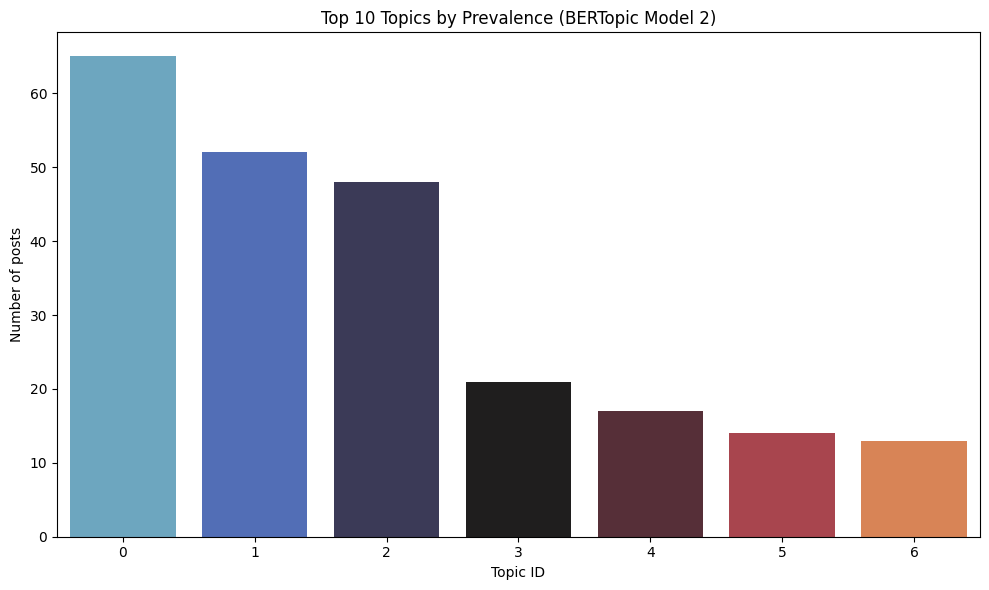

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Top 10 Topics by Prevalence (Model 2) ---
topic_sizes2 = df_topic2[df_topic2["topic_id"] != -1]["topic_id"].value_counts().head(10)

plt.figure(figsize=(10, 6))

# Applying the cubehelix palette
# Using hue=x and legend=False to follow the latest Seaborn standards
sns.barplot(
    x=topic_sizes2.index.astype(str),
    y=topic_sizes2.values,
    palette="icefire",
    hue=topic_sizes2.index.astype(str),
    legend=False
)

plt.xlabel("Topic ID")
plt.ylabel("Number of posts")
plt.title("Top 10 Topics by Prevalence (BERTopic Model 2)")
plt.tight_layout()
plt.show()

In [32]:
def topic_keywords2(topic_id: int, top_n: int = 12) -> str:
    words = topic_model2.get_topic(topic_id) or []
    return ", ".join([w for w, _ in words[:top_n]])

rows = []
for tid in top_topics2:
    rows.append({
        "topic_id": tid,
        "size": int((df_topic2["topic_id"] == tid).sum()),
        "keywords": topic_keywords2(tid, top_n=12),
    })

topic_summary2 = pd.DataFrame(rows).sort_values("size", ascending=False)
display(topic_summary2)


,topic_id,size,keywords
0,0,65,"games, game, like, 000, just, duty, cod, time, gaming, people"
1,1,52,"ai, art, use, generated, ai generated, game, using, generative, used, generative ai"
2,2,48,"10, game, series, experience, world, new, elden, elden ring, ring, rpg"
3,3,21,"game, work, time, just, don, like, ai, really, ve, working"
4,4,17,"property, private, end, sub, playerbase, ai, public, range, long, just"
5,5,14,"claims, claim, character, game, cheat, sub, prior, anti cheat, control, anti"
6,6,13,"ai, npc, dialogue, voice, game, player, know, npcs, say, ask"


In [33]:
topic_by_usecase2 = pd.crosstab(df_topic2["topic_label"], df_topic2["ai_use_case"])
display(topic_by_usecase2)

topic_by_usecase2_pct = (topic_by_usecase2.div(topic_by_usecase2.sum(axis=1), axis=0) * 100).round(1)
display(topic_by_usecase2_pct)


ai_use_case,gameplay_ai,image_generation,moderation_ai
topic_label,,,
"AI NPC dialogue, voice, and AI-driven characters",9,4,0
"AI-generated art debate (use in games, controversy, comparisons)",4,46,2
Cheating / anti-cheat / moderation & policy disputes,7,4,3
"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",13,2,2
"General gaming reflections (nostalgia, difficulty, big-game talk)",12,51,2
"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",10,11,0
"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",22,25,1
Unclustered / mixed topics,29,35,5


ai_use_case,gameplay_ai,image_generation,moderation_ai
topic_label,,,
"AI NPC dialogue, voice, and AI-driven characters",69.2,30.8,0.0
"AI-generated art debate (use in games, controversy, comparisons)",7.7,88.5,3.8
Cheating / anti-cheat / moderation & policy disputes,50.0,28.6,21.4
"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",76.5,11.8,11.8
"General gaming reflections (nostalgia, difficulty, big-game talk)",18.5,78.5,3.1
"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",47.6,52.4,0.0
"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",45.8,52.1,2.1
Unclustered / mixed topics,42.0,50.7,7.2


In [34]:
topic_by_sent2 = pd.crosstab(df_topic2["topic_label"], df_topic2["sentiment_label"])
display(topic_by_sent2)

topic_by_sent2_pct = (topic_by_sent2.div(topic_by_sent2.sum(axis=1), axis=0) * 100).round(1)
display(topic_by_sent2_pct)


sentiment_label,negative,neutral,positive
topic_label,,,
"AI NPC dialogue, voice, and AI-driven characters",2,0,11
"AI-generated art debate (use in games, controversy, comparisons)",13,9,30
Cheating / anti-cheat / moderation & policy disputes,9,1,4
"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",10,0,7
"General gaming reflections (nostalgia, difficulty, big-game talk)",18,2,45
"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",3,0,18
"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",8,0,40
Unclustered / mixed topics,18,1,50


sentiment_label,negative,neutral,positive
topic_label,,,
"AI NPC dialogue, voice, and AI-driven characters",15.4,0.0,84.6
"AI-generated art debate (use in games, controversy, comparisons)",25.0,17.3,57.7
Cheating / anti-cheat / moderation & policy disputes,64.3,7.1,28.6
"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",58.8,0.0,41.2
"General gaming reflections (nostalgia, difficulty, big-game talk)",27.7,3.1,69.2
"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",14.3,0.0,85.7
"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",16.7,0.0,83.3
Unclustered / mixed topics,26.1,1.4,72.5


In [35]:
# Build text -> index lookup so we can map representative docs back to rows
text_to_idx2 = {}
for i, t in df_topic2["text_for_topic"].items():
    if isinstance(t, str) and t not in text_to_idx2:
        text_to_idx2[t] = i

def show_topic_examples2(topic_id: int, n: int = 5):
    reps = topic_model2.get_representative_docs(topic_id) or []
    reps = reps[:n]
    out = []
    for doc in reps:
        idx = text_to_idx2.get(doc, None)
        if idx is None:
            out.append({
                "topic_id": topic_id, "ai_use_case": "", "sentiment": "",
                "title": "(not matched)", "permalink": "", "excerpt": doc[:220] + "..."
            })
        else:
            out.append({
                "topic_id": topic_id,
                "ai_use_case": df_topic2.loc[idx, "ai_use_case"],
                "sentiment": df_topic2.loc[idx, "sentiment_label"],
                "title": df_topic2.loc[idx, "title"],
                "permalink": df_topic2.loc[idx, "permalink"],
                "excerpt": str(df_topic2.loc[idx, "text_for_topic"])[:220] + "..."
            })
    return pd.DataFrame(out)

for tid in top_topics2:
    print(f"\n--- Topic {tid} ---")
    display(show_topic_examples2(tid, n=5))

print("\n--- Outliers (-1): Unclustered / misc ---")
display(show_topic_examples2(-1, n=5))



--- Topic 0 ---


,topic_id,ai_use_case,sentiment,title,permalink,excerpt
0,0,image_generation,positive,[LONG] We scale difficulty - Can narrative and systems scale too?,https://www.reddit.com/r/truegaming/comments/1p19gju/long_we_scale_difficulty_can_narrative_and/,[LONG] We scale difficulty - Can narrative and systems scale too? For years we've been observing how established studios attempt to broaden the audience of their games. # Attracting more players Implementing multiple dif...
1,0,gameplay_ai,positive,How I rekindled my excitement for video games,https://www.reddit.com/r/gaming/comments/1kjl2ro/how_i_rekindled_my_excitement_for_video_games/,"How I rekindled my excitement for video games I'm almost 40 years old and can't remember a time when I haven't been gaming. It's always been one of my favourite pastimes. I love exploring worlds, solving intricate puzzle..."
2,0,image_generation,negative,I Miss Gaming in the 2000s,https://www.reddit.com/r/truegaming/comments/1lvh3fk/i_miss_gaming_in_the_2000s/,"*(This is an essay I wrote about gaming that touches on a wealthy of subjects, I would love to see how you all view my framing and thoughts. And other details and connections I left out)* This began as an attempt to roma..."



--- Topic 1 ---


,topic_id,ai_use_case,sentiment,title,permalink,excerpt
0,1,image_generation,positive,Would you ever play a game that uses AI? Where would you draw the line?,https://www.reddit.com/r/pcgaming/comments/1mx8fym/would_you_ever_play_a_game_that_uses_ai_where/,Would you ever play a game that uses AI? Where would you draw the line? Every day more and more games use AI. Just recently a study came out that about 90% of game developers use AI one way or the other during the game d...
1,1,image_generation,positive,"With the recent E33 AI controversy, how much use of AI is acceptable?",https://www.reddit.com/r/gamedev/comments/1psxsvr/with_the_recent_e33_ai_controversy_how_much_use/,"With the recent E33 AI controversy, how much use of AI is acceptable? So Expedition 33 used placeholder AI assets, which were replaced for the release thus still being fully human made. Despite this there is quite a lot ..."
2,1,image_generation,positive,Do you view AI programming from AI generated art?,https://www.reddit.com/r/gamedev/comments/1mq9x1l/do_you_view_ai_programming_from_ai_generated_art/,Do you view AI programming from AI generated art? Edit: and of course I borked the title. Do you view AI programming *differently* from AI generated art? Is the apparent lack of concern around AI programming in games (as...



--- Topic 2 ---


,topic_id,ai_use_case,sentiment,title,permalink,excerpt
0,2,image_generation,positive,Elden Ring: Nightreign Review Thread,https://www.reddit.com/r/Games/comments/1kxhujv/elden_ring_nightreign_review_thread/,"Elden Ring: Nightreign Review Thread Game Information -------------------- **Game Title**: Elden Ring: Nightreign **Platforms**: - Xbox Series X/S (May 29, 2025) - PlayStation 5 (May 29, 2025) - PC (May 29, 2025) - Xbox ..."
1,2,image_generation,positive,The Outer Worlds 2 Review Thread,https://www.reddit.com/r/pcgaming/comments/1oe2nd6/the_outer_worlds_2_review_thread/,"The Outer Worlds 2 Review Thread Game Information -------------------- **Game Title**: The Outer Worlds 2 **Platforms**: - Xbox Series X/S (Oct 29, 2025) - PC (Oct 29, 2025) - PlayStation 5 (Oct 29, 2025) **Trailer**: - ..."
2,2,gameplay_ai,positive,The Outer Worlds 2 Review Thread,https://www.reddit.com/r/Games/comments/1oe2n8t/the_outer_worlds_2_review_thread/,"The Outer Worlds 2 Review Thread Game Information -------------------- **Game Title**: The Outer Worlds 2 **Platforms**: - Xbox Series X/S (Oct 29, 2025) - PC (Oct 29, 2025) - PlayStation 5 (Oct 29, 2025) **Trailer**: - ..."



--- Topic 3 ---


,topic_id,ai_use_case,sentiment,title,permalink,excerpt
0,3,image_generation,positive,Post-mortem: When (naïve) expectations don't match reality.,https://www.reddit.com/r/gamedev/comments/1ptpiqa/postmortem_when_naïve_expectations_dont_match/,"Post-mortem: When (naïve) expectations don't match reality. **Hi everyone,** On November 3rd I launched my second game called Realms of Madness. It is a sidescroller castlebuilder RTS game where you build a fantasy medie..."
1,3,image_generation,positive,47 days to demo. 47 gamedev lessons I learned the hard way,https://www.reddit.com/r/gamedev/comments/1pe3hbu/47_days_to_demo_47_gamedev_lessons_i_learned_the/,"47 days to demo. 47 gamedev lessons I learned the hard way In 47 days I plan to release The Maker Way’s demo on Steam, and I’ve been reflecting on the feedback from the currently running open playtest and the journey so ..."
2,3,image_generation,positive,"7 years trying to live off my own games: what went right, what went wrong, and what finally worked",https://www.reddit.com/r/gamedev/comments/1plm098/7_years_trying_to_live_off_my_own_games_what_went/,"7 years trying to live off my own games: what went right, what went wrong, and what finally worked Hi! My name is Javier/Delunado, and I’ve been making games for around 7 years now, mostly as a programmer and designer. W..."



--- Topic 4 ---


,topic_id,ai_use_case,sentiment,title,permalink,excerpt
0,4,gameplay_ai,positive,How come mob Ai still lags behind in games?,https://www.reddit.com/r/pcgaming/comments/1huaw7y/how_come_mob_ai_still_lags_behind_in_games/,"How come mob Ai still lags behind in games? To be clear, my point doesn't revolve solely around difficulty Good enemy AI imo isn't necessarily one that performs every action flawlessly to demolish you, there's no need to..."
1,4,image_generation,negative,15 questions for game devs.,https://www.reddit.com/r/gamedev/comments/1lmhywq/15_questions_for_game_devs/,"15 questions for game devs. So I play a ton of games. and I have noticed some things that while not in every single game they are common enough occurrences to make me ask ""why"" so hopefully I can get those answers. \#1. ..."
2,4,gameplay_ai,negative,Need help on Architecture,https://www.reddit.com/r/gamedev/comments/1ojuh79/need_help_on_architecture/,"Need help on Architecture Hello there, i am creating a pokemon-like game in excel. So far i have a system, where i can move on a map and fight NPC´s. I got the system running so far, but i have ambitions for this project..."



--- Topic 5 ---


,topic_id,ai_use_case,sentiment,title,permalink,excerpt
0,5,gameplay_ai,negative,[COD] The game being 17+ does not mean you can say anything over voice/text,https://www.reddit.com/r/CallOfDuty/comments/1i7ps6g/cod_the_game_being_17_does_not_mean_you_can_say/,"[COD] The game being 17+ does not mean you can say anything over voice/text Why do I need to make a post like this when it's obvious? Nevertheless, the community continues to spread brainrot for the sake of ""freedom of s..."
1,5,moderation_ai,positive,Blizzard Anti-Cheat Director Interview,https://www.reddit.com/r/gamedev/comments/1klvkp2/blizzard_anticheat_director_interview/,"Blizzard Anti-Cheat Director Interview Hey guys, I recently had the pleasure of interviewing the director of anti-cheat at Blizzard, and I wanted to share it with you all. Below is a summary of the discussion, with best-..."
2,5,moderation_ai,positive,"Dispelling some common misconceptions about Nintendo's US Patent 12,403,397.",https://www.reddit.com/r/gamedev/comments/1ni7v24/dispelling_some_common_misconceptions_about/,"Dispelling some common misconceptions about Nintendo's US Patent 12,403,397. Hi, I'm a law student and a gamer, and I was recently quite drawn to the news of [Nintendo's US Patent 12,403,397]( which several news outlets ..."



--- Topic 6 ---


,topic_id,ai_use_case,sentiment,title,permalink,excerpt
0,6,gameplay_ai,positive,"Though AI has been used in video games for a considerable number of years, can new AI, similar to that of CHATGPT, have a place in future video games?",https://www.reddit.com/r/truegaming/comments/1mi2qhq/though_ai_has_been_used_in_video_games_for_a/,"Though AI has been used in video games for a considerable number of years, can new AI, similar to that of CHATGPT, have a place in future video games? We know that AI has been used before. Enemy AI, physics engines, proc..."
1,6,gameplay_ai,positive,Arcadia Unbound - Tactical JRPG with AI-Driven Character Dialogue,https://www.reddit.com/r/gamedev/comments/1oqtd17/arcadia_unbound_tactical_jrpg_with_aidriven/,"Arcadia Unbound - Tactical JRPG with AI-Driven Character Dialogue Hey everyone! I’ve been working on something exciting over the past few months, a game called Arcadia Unbound which is a tactical JRPG inspired by Final F..."
2,6,gameplay_ai,negative,Why AI MLM written NPC dialogue will never happen.,https://www.reddit.com/r/gaming/comments/1nlyjxp/why_ai_mlm_written_npc_dialogue_will_never_happen/,"Why AI MLM written NPC dialogue will never happen. Nvidia is still on the AI hype train despite the bubble being ready to burst any day now. They say AI (machine learning algorithms specifically) will be the future, that..."



--- Outliers (-1): Unclustered / misc ---


,topic_id,ai_use_case,sentiment,title,permalink,excerpt
0,-1,image_generation,positive,Three strands of thought on Death Stranding 2 (no spoilers),https://www.reddit.com/r/truegaming/comments/1mkbkcs/three_strands_of_thought_on_death_stranding_2_no/,"Three strands of thought on Death Stranding 2 (no spoilers) 80 hours in, the credits have rolled, and boy do I have a few thoughts on this odd game, especially as I didn't play the first and - I'll be honest - my only pr..."
1,-1,image_generation,positive,"New extensive interview with Fumito Ueda (Ico, Shadow of the Colossus, more) and Keita Takahashi (Katamari Damacy, We Love Katamari, more)!",https://www.reddit.com/r/truegaming/comments/1m2lgox/new_extensive_interview_with_fumito_ueda_ico/,"New extensive interview with Fumito Ueda (Ico, Shadow of the Colossus, more) and Keita Takahashi (Katamari Damacy, We Love Katamari, more)! From -- translated to English below: Keita Takahashi is a game designer best kno..."
2,-1,image_generation,positive,"New extensive interview with Fumito Ueda (Ico, Shadow of the Colossus, more) and Keita Takahashi (Katamari Damacy, We Love Katamari, more)!",https://www.reddit.com/r/truegaming/comments/1m2lgox/new_extensive_interview_with_fumito_ueda_ico/,"New extensive interview with Fumito Ueda (Ico, Shadow of the Colossus, more) and Keita Takahashi (Katamari Damacy, We Love Katamari, more)! From -- translated to English below: Keita Takahashi is a game designer best kno..."


In [36]:
topic_table_final = (
    df_topic2["topic_label"]
    .value_counts()
    .rename_axis("topic_label")
    .reset_index(name="count")
)

topic_table_final["percent"] = (topic_table_final["count"] / len(df_topic2) * 100).round(1)
display(topic_table_final)


,topic_label,count,percent
0,Unclustered / mixed topics,69,23.1
1,"General gaming reflections (nostalgia, difficulty, big-game talk)",65,21.7
2,"AI-generated art debate (use in games, controversy, comparisons)",52,17.4
3,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",48,16.1
4,"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",21,7.0
5,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",17,5.7
6,Cheating / anti-cheat / moderation & policy disputes,14,4.7
7,"AI NPC dialogue, voice, and AI-driven characters",13,4.3


In [37]:
print("df_analysis rows:", len(df_analysis))
print("df_topic2 rows (used for BERTopic):", len(df_topic2))
print("Outliers %:", round((df_topic2["topic_id"] == -1).mean()*100, 1))


df_analysis rows: 299
df_topic2 rows (used for BERTopic): 299
Outliers %: 23.1


# **Topic Interpretation and Examples**

In [38]:
# Build a text -> index lookup to map representative docs back to df rows
text_to_idx2 = {}
for i, t in df_topic2["text_for_topic"].items():
    if isinstance(t, str) and t not in text_to_idx2:
        text_to_idx2[t] = i

def get_topic_examples(topic_id: int, n: int = 5):
    reps = topic_model2.get_representative_docs(topic_id) or []
    reps = reps[:n]
    rows = []
    for doc in reps:
        idx = text_to_idx2.get(doc, None)
        if idx is None:
            rows.append({
                "topic_id": topic_id,
                "topic_label": topic_labels2.get(topic_id, str(topic_id)) if "topic_labels2" in globals() else str(topic_id),
                "title": "(not matched)",
                "permalink": "",
                "ai_use_case": "",
                "sentiment_label": "",
                "excerpt": doc[:250] + "..."
            })
        else:
            rows.append({
                "topic_id": int(df_topic2.loc[idx, "topic_id"]),
                "topic_label": df_topic2.loc[idx, "topic_label"],
                "title": df_topic2.loc[idx, "title"],
                "permalink": df_topic2.loc[idx, "permalink"],
                "ai_use_case": df_topic2.loc[idx, "ai_use_case"],
                "sentiment_label": df_topic2.loc[idx, "sentiment_label"],
                "excerpt": str(df_topic2.loc[idx, "text_for_topic"])[:250] + "..."
            })
    return pd.DataFrame(rows)

# Show examples for each main topic (excluding outliers -1 by default)
for tid in top_topics2:
    print(f"\n=== {topic_labels2.get(tid, tid)} (Topic {tid}) ===")
    display(get_topic_examples(tid, n=5))

print("\n=== Unclustered / mixed topics (Topic -1) ===")
display(get_topic_examples(-1, n=5))



=== General gaming reflections (nostalgia, difficulty, big-game talk) (Topic 0) ===


,topic_id,topic_label,title,permalink,ai_use_case,sentiment_label,excerpt
0,0,"General gaming reflections (nostalgia, difficulty, big-game talk)",[LONG] We scale difficulty - Can narrative and systems scale too?,https://www.reddit.com/r/truegaming/comments/1p19gju/long_we_scale_difficulty_can_narrative_and/,image_generation,positive,[LONG] We scale difficulty - Can narrative and systems scale too? For years we've been observing how established studios attempt to broaden the audience of their games. # Attracting more players Implementing multiple difficulty levels into a game is ...
1,0,"General gaming reflections (nostalgia, difficulty, big-game talk)",How I rekindled my excitement for video games,https://www.reddit.com/r/gaming/comments/1kjl2ro/how_i_rekindled_my_excitement_for_video_games/,gameplay_ai,positive,"How I rekindled my excitement for video games I'm almost 40 years old and can't remember a time when I haven't been gaming. It's always been one of my favourite pastimes. I love exploring worlds, solving intricate puzzles, losing myself in gripping s..."
2,0,"General gaming reflections (nostalgia, difficulty, big-game talk)",I Miss Gaming in the 2000s,https://www.reddit.com/r/truegaming/comments/1lvh3fk/i_miss_gaming_in_the_2000s/,image_generation,negative,"*(This is an essay I wrote about gaming that touches on a wealthy of subjects, I would love to see how you all view my framing and thoughts. And other details and connections I left out)* This began as an attempt to romanticize midnight launches, the..."



=== AI-generated art debate (use in games, controversy, comparisons) (Topic 1) ===


,topic_id,topic_label,title,permalink,ai_use_case,sentiment_label,excerpt
0,1,"AI-generated art debate (use in games, controversy, comparisons)",Would you ever play a game that uses AI? Where would you draw the line?,https://www.reddit.com/r/pcgaming/comments/1mx8fym/would_you_ever_play_a_game_that_uses_ai_where/,image_generation,positive,Would you ever play a game that uses AI? Where would you draw the line? Every day more and more games use AI. Just recently a study came out that about 90% of game developers use AI one way or the other during the game development process. When do yo...
1,1,"AI-generated art debate (use in games, controversy, comparisons)","With the recent E33 AI controversy, how much use of AI is acceptable?",https://www.reddit.com/r/gamedev/comments/1psxsvr/with_the_recent_e33_ai_controversy_how_much_use/,image_generation,positive,"With the recent E33 AI controversy, how much use of AI is acceptable? So Expedition 33 used placeholder AI assets, which were replaced for the release thus still being fully human made. Despite this there is quite a lot of controversy with it even be..."
2,1,"AI-generated art debate (use in games, controversy, comparisons)",Do you view AI programming from AI generated art?,https://www.reddit.com/r/gamedev/comments/1mq9x1l/do_you_view_ai_programming_from_ai_generated_art/,image_generation,positive,Do you view AI programming from AI generated art? Edit: and of course I borked the title. Do you view AI programming *differently* from AI generated art? Is the apparent lack of concern around AI programming in games (as opposed to AI art in games) o...



=== Major game reviews / release threads (Elden Ring, Outer Worlds, etc.) (Topic 2) ===


,topic_id,topic_label,title,permalink,ai_use_case,sentiment_label,excerpt
0,2,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",Elden Ring: Nightreign Review Thread,https://www.reddit.com/r/Games/comments/1kxhujv/elden_ring_nightreign_review_thread/,image_generation,positive,"Elden Ring: Nightreign Review Thread Game Information -------------------- **Game Title**: Elden Ring: Nightreign **Platforms**: - Xbox Series X/S (May 29, 2025) - PlayStation 5 (May 29, 2025) - PC (May 29, 2025) - Xbox One (May 29, 2025) - PlayStati..."
1,2,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",The Outer Worlds 2 Review Thread,https://www.reddit.com/r/pcgaming/comments/1oe2nd6/the_outer_worlds_2_review_thread/,image_generation,positive,"The Outer Worlds 2 Review Thread Game Information -------------------- **Game Title**: The Outer Worlds 2 **Platforms**: - Xbox Series X/S (Oct 29, 2025) - PC (Oct 29, 2025) - PlayStation 5 (Oct 29, 2025) **Trailer**: - [The Outer Worlds 2 - Official..."
2,2,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",The Outer Worlds 2 Review Thread,https://www.reddit.com/r/Games/comments/1oe2n8t/the_outer_worlds_2_review_thread/,gameplay_ai,positive,"The Outer Worlds 2 Review Thread Game Information -------------------- **Game Title**: The Outer Worlds 2 **Platforms**: - Xbox Series X/S (Oct 29, 2025) - PC (Oct 29, 2025) - PlayStation 5 (Oct 29, 2025) **Trailer**: - [The Outer Worlds 2 - Official..."



=== Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability) (Topic 3) ===


,topic_id,topic_label,title,permalink,ai_use_case,sentiment_label,excerpt
0,3,"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",Post-mortem: When (naïve) expectations don't match reality.,https://www.reddit.com/r/gamedev/comments/1ptpiqa/postmortem_when_naïve_expectations_dont_match/,image_generation,positive,"Post-mortem: When (naïve) expectations don't match reality. **Hi everyone,** On November 3rd I launched my second game called Realms of Madness. It is a sidescroller castlebuilder RTS game where you build a fantasy medieval castle and control mythica..."
1,3,"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",47 days to demo. 47 gamedev lessons I learned the hard way,https://www.reddit.com/r/gamedev/comments/1pe3hbu/47_days_to_demo_47_gamedev_lessons_i_learned_the/,image_generation,positive,"47 days to demo. 47 gamedev lessons I learned the hard way In 47 days I plan to release The Maker Way’s demo on Steam, and I’ve been reflecting on the feedback from the currently running open playtest and the journey so far. I collected here the 47 m..."
2,3,"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)","7 years trying to live off my own games: what went right, what went wrong, and what finally worked",https://www.reddit.com/r/gamedev/comments/1plm098/7_years_trying_to_live_off_my_own_games_what_went/,image_generation,positive,"7 years trying to live off my own games: what went right, what went wrong, and what finally worked Hi! My name is Javier/Delunado, and I’ve been making games for around 7 years now, mostly as a programmer and designer. Warning! This is going to be a ..."



=== Gameplay AI limitations & dev Qs (mob AI, architecture, design questions) (Topic 4) ===


,topic_id,topic_label,title,permalink,ai_use_case,sentiment_label,excerpt
0,4,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",How come mob Ai still lags behind in games?,https://www.reddit.com/r/pcgaming/comments/1huaw7y/how_come_mob_ai_still_lags_behind_in_games/,gameplay_ai,positive,"How come mob Ai still lags behind in games? To be clear, my point doesn't revolve solely around difficulty Good enemy AI imo isn't necessarily one that performs every action flawlessly to demolish you, there's no need to prove that AI can and will be..."
1,4,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",15 questions for game devs.,https://www.reddit.com/r/gamedev/comments/1lmhywq/15_questions_for_game_devs/,image_generation,negative,"15 questions for game devs. So I play a ton of games. and I have noticed some things that while not in every single game they are common enough occurrences to make me ask ""why"" so hopefully I can get those answers. \#1. Why are npc teammates / partne..."
2,4,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",Need help on Architecture,https://www.reddit.com/r/gamedev/comments/1ojuh79/need_help_on_architecture/,gameplay_ai,negative,"Need help on Architecture Hello there, i am creating a pokemon-like game in excel. So far i have a system, where i can move on a map and fight NPC´s. I got the system running so far, but i have ambitions for this project, mainly multiplayer through a..."



=== Cheating / anti-cheat / moderation & policy disputes (Topic 5) ===


,topic_id,topic_label,title,permalink,ai_use_case,sentiment_label,excerpt
0,5,Cheating / anti-cheat / moderation & policy disputes,[COD] The game being 17+ does not mean you can say anything over voice/text,https://www.reddit.com/r/CallOfDuty/comments/1i7ps6g/cod_the_game_being_17_does_not_mean_you_can_say/,gameplay_ai,negative,"[COD] The game being 17+ does not mean you can say anything over voice/text Why do I need to make a post like this when it's obvious? Nevertheless, the community continues to spread brainrot for the sake of ""freedom of speech"" with a touch of misinfo..."
1,5,Cheating / anti-cheat / moderation & policy disputes,Blizzard Anti-Cheat Director Interview,https://www.reddit.com/r/gamedev/comments/1klvkp2/blizzard_anticheat_director_interview/,moderation_ai,positive,"Blizzard Anti-Cheat Director Interview Hey guys, I recently had the pleasure of interviewing the director of anti-cheat at Blizzard, and I wanted to share it with you all. Below is a summary of the discussion, with best-effort timestamps. # Backgroun..."
2,5,Cheating / anti-cheat / moderation & policy disputes,"Dispelling some common misconceptions about Nintendo's US Patent 12,403,397.",https://www.reddit.com/r/gamedev/comments/1ni7v24/dispelling_some_common_misconceptions_about/,moderation_ai,positive,"Dispelling some common misconceptions about Nintendo's US Patent 12,403,397. Hi, I'm a law student and a gamer, and I was recently quite drawn to the news of [Nintendo's US Patent 12,403,397]( which several news outlets reported as a patent that shou..."



=== AI NPC dialogue, voice, and AI-driven characters (Topic 6) ===


,topic_id,topic_label,title,permalink,ai_use_case,sentiment_label,excerpt
0,6,"AI NPC dialogue, voice, and AI-driven characters","Though AI has been used in video games for a considerable number of years, can new AI, similar to that of CHATGPT, have a place in future video games?",https://www.reddit.com/r/truegaming/comments/1mi2qhq/though_ai_has_been_used_in_video_games_for_a/,gameplay_ai,positive,"Though AI has been used in video games for a considerable number of years, can new AI, similar to that of CHATGPT, have a place in future video games? We know that AI has been used before. Enemy AI, physics engines, procedurally generated maps and no..."
1,6,"AI NPC dialogue, voice, and AI-driven characters",Arcadia Unbound - Tactical JRPG with AI-Driven Character Dialogue,https://www.reddit.com/r/gamedev/comments/1oqtd17/arcadia_unbound_tactical_jrpg_with_aidriven/,gameplay_ai,positive,"Arcadia Unbound - Tactical JRPG with AI-Driven Character Dialogue Hey everyone! I’ve been working on something exciting over the past few months, a game called Arcadia Unbound which is a tactical JRPG inspired by Final Fantasy Tactics and Triangle St..."
2,6,"AI NPC dialogue, voice, and AI-driven characters",Why AI MLM written NPC dialogue will never happen.,https://www.reddit.com/r/gaming/comments/1nlyjxp/why_ai_mlm_written_npc_dialogue_will_never_happen/,gameplay_ai,negative,"Why AI MLM written NPC dialogue will never happen. Nvidia is still on the AI hype train despite the bubble being ready to burst any day now. They say AI (machine learning algorithms specifically) will be the future, that you'll be able to have conver..."



=== Unclustered / mixed topics (Topic -1) ===


,topic_id,topic_label,title,permalink,ai_use_case,sentiment_label,excerpt
0,-1,Unclustered / mixed topics,Three strands of thought on Death Stranding 2 (no spoilers),https://www.reddit.com/r/truegaming/comments/1mkbkcs/three_strands_of_thought_on_death_stranding_2_no/,image_generation,positive,"Three strands of thought on Death Stranding 2 (no spoilers) 80 hours in, the credits have rolled, and boy do I have a few thoughts on this odd game, especially as I didn't play the first and - I'll be honest - my only prior experience with a Kojima g..."
1,-1,Unclustered / mixed topics,"New extensive interview with Fumito Ueda (Ico, Shadow of the Colossus, more) and Keita Takahashi (Katamari Damacy, We Love Katamari, more)!",https://www.reddit.com/r/truegaming/comments/1m2lgox/new_extensive_interview_with_fumito_ueda_ico/,image_generation,positive,"New extensive interview with Fumito Ueda (Ico, Shadow of the Colossus, more) and Keita Takahashi (Katamari Damacy, We Love Katamari, more)! From -- translated to English below: Keita Takahashi is a game designer best known for directing Katamari Dama..."
2,-1,Unclustered / mixed topics,"New extensive interview with Fumito Ueda (Ico, Shadow of the Colossus, more) and Keita Takahashi (Katamari Damacy, We Love Katamari, more)!",https://www.reddit.com/r/truegaming/comments/1m2lgox/new_extensive_interview_with_fumito_ueda_ico/,image_generation,positive,"New extensive interview with Fumito Ueda (Ico, Shadow of the Colossus, more) and Keita Takahashi (Katamari Damacy, We Love Katamari, more)! From -- translated to English below: Keita Takahashi is a game designer best known for directing Katamari Dama..."


In [39]:
def topic_keywords2(topic_id: int, top_n: int = 12) -> str:
    words = topic_model2.get_topic(topic_id) or []
    return ", ".join([w for w, _ in words[:top_n]])

def safe_excerpt(text, n=180):
    if pd.isna(text):
        return ""
    text = str(text).replace("\n", " ").strip()
    return (text[:n] + "...") if len(text) > n else text

rows = []
for tid in top_topics2:
    # pick 2 representative docs and map to rows
    reps = topic_model2.get_representative_docs(tid) or []
    reps = reps[:2]
    examples = []
    for doc in reps:
        idx = text_to_idx2.get(doc, None)
        if idx is None:
            examples.append({"title": "(not matched)", "permalink": "", "excerpt": safe_excerpt(doc)})
        else:
            examples.append({
                "title": df_topic2.loc[idx, "title"],
                "permalink": df_topic2.loc[idx, "permalink"],
                "excerpt": safe_excerpt(df_topic2.loc[idx, "text_for_topic"])
            })

    rows.append({
        "topic_id": tid,
        "topic_label": topic_labels2.get(tid, str(tid)),
        "count": int((df_topic2["topic_id"] == tid).sum()),
        "percent": round((df_topic2["topic_id"] == tid).mean() * 100, 1),
        "keywords": topic_keywords2(tid, top_n=12),
        "example_1_title": examples[0]["title"] if len(examples) > 0 else "",
        "example_1_link": examples[0]["permalink"] if len(examples) > 0 else "",
        "example_1_excerpt": examples[0]["excerpt"] if len(examples) > 0 else "",
        "example_2_title": examples[1]["title"] if len(examples) > 1 else "",
        "example_2_link": examples[1]["permalink"] if len(examples) > 1 else "",
        "example_2_excerpt": examples[1]["excerpt"] if len(examples) > 1 else "",
    })

topic_examples_table = pd.DataFrame(rows).sort_values("count", ascending=False)
display(topic_examples_table)


,topic_id,topic_label,count,percent,keywords,example_1_title,example_1_link,example_1_excerpt,example_2_title,example_2_link,example_2_excerpt
0,0,"General gaming reflections (nostalgia, difficulty, big-game talk)",65,21.7,"games, game, like, 000, just, duty, cod, time, gaming, people",[LONG] We scale difficulty - Can narrative and systems scale too?,https://www.reddit.com/r/truegaming/comments/1p19gju/long_we_scale_difficulty_can_narrative_and/,[LONG] We scale difficulty - Can narrative and systems scale too? For years we've been observing how established studios attempt to broaden the audience of their games. # Attractin...,How I rekindled my excitement for video games,https://www.reddit.com/r/gaming/comments/1kjl2ro/how_i_rekindled_my_excitement_for_video_games/,How I rekindled my excitement for video games I'm almost 40 years old and can't remember a time when I haven't been gaming. It's always been one of my favourite pastimes. I love ex...
1,1,"AI-generated art debate (use in games, controversy, comparisons)",52,17.4,"ai, art, use, generated, ai generated, game, using, generative, used, generative ai",Would you ever play a game that uses AI? Where would you draw the line?,https://www.reddit.com/r/pcgaming/comments/1mx8fym/would_you_ever_play_a_game_that_uses_ai_where/,Would you ever play a game that uses AI? Where would you draw the line? Every day more and more games use AI. Just recently a study came out that about 90% of game developers use A...,"With the recent E33 AI controversy, how much use of AI is acceptable?",https://www.reddit.com/r/gamedev/comments/1psxsvr/with_the_recent_e33_ai_controversy_how_much_use/,"With the recent E33 AI controversy, how much use of AI is acceptable? So Expedition 33 used placeholder AI assets, which were replaced for the release thus still being fully human ..."
2,2,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",48,16.1,"10, game, series, experience, world, new, elden, elden ring, ring, rpg",Elden Ring: Nightreign Review Thread,https://www.reddit.com/r/Games/comments/1kxhujv/elden_ring_nightreign_review_thread/,"Elden Ring: Nightreign Review Thread Game Information -------------------- **Game Title**: Elden Ring: Nightreign **Platforms**: - Xbox Series X/S (May 29, 2025) - PlayStation 5 (M...",The Outer Worlds 2 Review Thread,https://www.reddit.com/r/pcgaming/comments/1oe2nd6/the_outer_worlds_2_review_thread/,"The Outer Worlds 2 Review Thread Game Information -------------------- **Game Title**: The Outer Worlds 2 **Platforms**: - Xbox Series X/S (Oct 29, 2025) - PC (Oct 29, 2025) - Play..."
3,3,"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",21,7.0,"game, work, time, just, don, like, ai, really, ve, working",Post-mortem: When (naïve) expectations don't match reality.,https://www.reddit.com/r/gamedev/comments/1ptpiqa/postmortem_when_naïve_expectations_dont_match/,"Post-mortem: When (naïve) expectations don't match reality. **Hi everyone,** On November 3rd I launched my second game called Realms of Madness. It is a sidescroller castlebuilder ...",47 days to demo. 47 gamedev lessons I learned the hard way,https://www.reddit.com/r/gamedev/comments/1pe3hbu/47_days_to_demo_47_gamedev_lessons_i_learned_the/,"47 days to demo. 47 gamedev lessons I learned the hard way In 47 days I plan to release The Maker Way’s demo on Steam, and I’ve been reflecting on the feedback from the currently r..."
4,4,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",17,5.7,"property, private, end, sub, playerbase, ai, public, range, long, just",How come mob Ai still lags behind in games?,https://www.reddit.com/r/pcgaming/comments/1huaw7y/how_come_mob_ai_still_lags_behind_in_games/,"How come mob Ai still lags behind in games? To be clear, my point doesn't revolve solely around difficulty Good enemy AI imo isn't necessarily one that performs every action flawle...",15 questions for game devs.,https://www.reddit.com/r/gamedev/comments/

In [40]:
out_dir = Path("/content/outputs")
out_dir.mkdir(parents=True, exist_ok=True)

topic_examples_path = out_dir / "topic_examples_table.csv"
topic_examples_table.to_csv(topic_examples_path, index=False)

topic_sent_pct_path = out_dir / "topic_by_sentiment_pct.csv"
topic_by_sent2_pct.to_csv(topic_sent_pct_path)

topic_usecase_pct_path = out_dir / "topic_by_usecase_pct.csv"
topic_by_usecase2_pct.to_csv(topic_usecase_pct_path)

print("Saved:")
print(topic_examples_path)
print(topic_sent_pct_path)
print(topic_usecase_pct_path)


Saved:
/content/outputs/topic_examples_table.csv
/content/outputs/topic_by_sentiment_pct.csv
/content/outputs/topic_by_usecase_pct.csv


In [41]:
# Top extreme sentiment posts per topic
cols_show = ["topic_label", "ai_use_case", "sentiment_label", "compound", "log_engagement", "title", "permalink"]

extremes = []
for label, g in df_topic2[df_topic2["topic_id"] != -1].groupby("topic_label"):
    g_sorted_neg = g.sort_values("compound").head(2)
    g_sorted_pos = g.sort_values("compound", ascending=False).head(2)
    extremes.append(("Most negative", label, g_sorted_neg[cols_show]))
    extremes.append(("Most positive", label, g_sorted_pos[cols_show]))

for kind, label, table in extremes:
    print(f"\n--- {kind} in topic: {label} ---")
    display(table)



--- Most negative in topic: AI NPC dialogue, voice, and AI-driven characters ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
188,"AI NPC dialogue, voice, and AI-driven characters",gameplay_ai,negative,-0.9742,4.290459,Why AI MLM written NPC dialogue will never happen.,https://www.reddit.com/r/gaming/comments/1nlyjxp/why_ai_mlm_written_npc_dialogue_will_never_happen/
263,"AI NPC dialogue, voice, and AI-driven characters",gameplay_ai,negative,-0.8768,3.806662,"What do you prefer for a serious game: AI voice lines, voice lines performed by dev and friends or just subtitles?",https://www.reddit.com/r/gamedev/comments/1p0b9f2/what_do_you_prefer_for_a_serious_game_ai_voice/



--- Most positive in topic: AI NPC dialogue, voice, and AI-driven characters ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
246,"AI NPC dialogue, voice, and AI-driven characters",gameplay_ai,positive,0.9962,4.574711,I'm searching for theoric resources about PvE AI... but not that AI. The old one. The videogame one.,https://www.reddit.com/r/gamedev/comments/1pf76wn/im_searching_for_theoric_resources_about_pve_ai/
265,"AI NPC dialogue, voice, and AI-driven characters",gameplay_ai,positive,0.9962,3.367296,Arcadia Unbound - Tactical JRPG with AI-Driven Character Dialogue,https://www.reddit.com/r/gamedev/comments/1oqtd17/arcadia_unbound_tactical_jrpg_with_aidriven/



--- Most negative in topic: AI-generated art debate (use in games, controversy, comparisons) ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
156,"AI-generated art debate (use in games, controversy, comparisons)",image_generation,negative,-0.9076,4.844187,Used GEN-AI(Claude) does Steam care? at best do the Users?,https://www.reddit.com/r/gamedev/comments/1pszgz3/used_genaiclaude_does_steam_care_at_best_do_the/
128,"AI-generated art debate (use in games, controversy, comparisons)",image_generation,negative,-0.8850,4.727388,How should devs handle curator reviews that make false ‘AI’ claims?,https://www.reddit.com/r/gamedev/comments/1pr677z/how_should_devs_handle_curator_reviews_that_make/



--- Most positive in topic: AI-generated art debate (use in games, controversy, comparisons) ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
143,"AI-generated art debate (use in games, controversy, comparisons)",image_generation,positive,0.9982,5.509388,Do you view AI programming from AI generated art?,https://www.reddit.com/r/gamedev/comments/1mq9x1l/do_you_view_ai_programming_from_ai_generated_art/
63,"AI-generated art debate (use in games, controversy, comparisons)",image_generation,positive,0.9961,8.596928,"Larian CEO Responds to Divinity Gen AI Backlash: 'We Are Neither Releasing a Game With Any AI Components, Nor Are We Looking at Trimming Down Teams to Replace Them With AI' - IGN",https://www.reddit.com/r/pcgaming/comments/1pocg69/larian_ceo_responds_to_divinity_gen_ai_backlash/



--- Most negative in topic: Cheating / anti-cheat / moderation & policy disputes ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
237,Cheating / anti-cheat / moderation & policy disputes,gameplay_ai,negative,-0.9977,4.859812,[COD] The game being 17+ does not mean you can say anything over voice/text,https://www.reddit.com/r/CallOfDuty/comments/1i7ps6g/cod_the_game_being_17_does_not_mean_you_can_say/
121,Cheating / anti-cheat / moderation & policy disputes,image_generation,negative,-0.9959,4.691348,randgrid.sys deployed a Tactical Nuke - wiped our squad before the game even started.,https://www.reddit.com/r/Warzone/comments/1l6ymb5/randgridsys_deployed_a_tactical_nuke_wiped_our/



--- Most positive in topic: Cheating / anti-cheat / moderation & policy disputes ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
291,Cheating / anti-cheat / moderation & policy disputes,moderation_ai,positive,0.9696,6.464588,"Dispelling some common misconceptions about Nintendo's US Patent 12,403,397.",https://www.reddit.com/r/gamedev/comments/1ni7v24/dispelling_some_common_misconceptions_about/
294,Cheating / anti-cheat / moderation & policy disputes,moderation_ai,positive,0.9599,3.663562,Blizzard Anti-Cheat Director Interview,https://www.reddit.com/r/gamedev/comments/1klvkp2/blizzard_anticheat_director_interview/



--- Most negative in topic: Gameplay AI limitations & dev Qs (mob AI, architecture, design questions) ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
146,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",image_generation,negative,-0.9993,3.218876,15 questions for game devs.,https://www.reddit.com/r/gamedev/comments/1lmhywq/15_questions_for_game_devs/
245,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",gameplay_ai,negative,-0.9887,2.484907,Need Help With Enemy Ai Decision Making,https://www.reddit.com/r/gamedev/comments/1pg6ac5/need_help_with_enemy_ai_decision_making/



--- Most positive in topic: Gameplay AI limitations & dev Qs (mob AI, architecture, design questions) ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
32,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",image_generation,positive,0.9955,2.833213,BOT.vinnik Chess Masters Academy - Deep Green Games - A puzzle game where a grumpy Soviet robot insults you until you learn chess,https://www.reddit.com/r/Games/comments/1omovfb/botvinnik_chess_masters_academy_deep_green_games/
257,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",gameplay_ai,positive,0.9951,3.135494,Help me improve on this questions I'll ask my prototype testers!!,https://www.reddit.com/r/gamedev/comments/1mpf8vu/help_me_improve_on_this_questions_ill_ask_my/



--- Most negative in topic: General gaming reflections (nostalgia, difficulty, big-game talk) ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
166,"General gaming reflections (nostalgia, difficulty, big-game talk)",image_generation,negative,-0.9973,4.204693,The deeper crisis behind the Steam Machine's 8GBs of VRAM,https://www.reddit.com/r/truegaming/comments/1p48ts0/the_deeper_crisis_behind_the_steam_machines_8gbs/
165,"General gaming reflections (nostalgia, difficulty, big-game talk)",image_generation,negative,-0.9949,7.177019,Why Is Game Optimization Getting Worse?,https://www.reddit.com/r/truegaming/comments/1p9wctv/why_is_game_optimization_getting_worse/



--- Most positive in topic: General gaming reflections (nostalgia, difficulty, big-game talk) ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
152,"General gaming reflections (nostalgia, difficulty, big-game talk)",image_generation,positive,0.9998,2.708050,Slaying the Incumbent: League of Legends,https://www.reddit.com/r/gamedev/comments/1joqmy4/slaying_the_incumbent_league_of_legends/
195,"General gaming reflections (nostalgia, difficulty, big-game talk)",gameplay_ai,positive,0.9997,5.442418,How I rekindled my excitement for video games,https://www.reddit.com/r/gaming/comments/1kjl2ro/how_i_rekindled_my_excitement_for_video_games/



--- Most negative in topic: Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability) ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
261,"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",gameplay_ai,negative,-0.9647,3.433987,"""Math disability""-like thing almost killed me as a gamedev and my dream to make a game",https://www.reddit.com/r/gamedev/comments/1p5isxr/math_disabilitylike_thing_almost_killed_me_as_a/
272,"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",gameplay_ai,negative,-0.6598,4.744932,Should i feel bad for using help from AI?,https://www.reddit.com/r/gamedev/comments/1nwkttb/should_i_feel_bad_for_using_help_from_ai/



--- Most positive in topic: Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability) ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
161,"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",image_generation,positive,0.9997,6.641182,"7 years trying to live off my own games: what went right, what went wrong, and what finally worked",https://www.reddit.com/r/gamedev/comments/1plm098/7_years_trying_to_live_off_my_own_games_what_went/
139,"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",image_generation,positive,0.9992,4.204693,47 days to demo. 47 gamedev lessons I learned the hard way,https://www.reddit.com/r/gamedev/comments/1pe3hbu/47_days_to_demo_47_gamedev_lessons_i_learned_the/



--- Most negative in topic: Major game reviews / release threads (Elden Ring, Outer Worlds, etc.) ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
274,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",gameplay_ai,negative,-0.9920,4.709530,Why do so many Metroidvanias have a spooky slant?,https://www.reddit.com/r/truegaming/comments/1ojotuq/why_do_so_many_metroidvanias_have_a_spooky_slant/
203,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",gameplay_ai,negative,-0.9867,2.197225,"Beneath - Camel101 - Action horror beneath the waves , a mix of F.E.A.R / Resident Evil (DEMO AVAILABLE UNTIL AUGUST 4TH)",https://www.reddit.com/r/Games/comments/1mgnset/beneath_camel101_action_horror_beneath_the_waves/



--- Most positive in topic: Major game reviews / release threads (Elden Ring, Outer Worlds, etc.) ---


,topic_label,ai_use_case,sentiment_label,compound,log_engagement,title,permalink
48,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",image_generation,positive,0.9999,5.241747,Super Mario Party Jamboree - Nintendo Switch 2 Edition + Jamboree TV Review Thread,https://www.reddit.com/r/Games/comments/1m7tm5g/super_mario_party_jamboree_nintendo_switch_2/
54,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",image_generation,positive,0.9999,6.523562,Marvel: Cosmic Invasion Review Thread,https://www.reddit.com/r/Games/comments/1pbgjbc/marvel_cosmic_invasion_review_thread/


# **Integrated Findings (Mixed-Methods Synthesis)**

In [42]:
import pandas as pd
import numpy as np

# Safety checks
assert "df_analysis" in globals(), "df_analysis not found. Run earlier steps."
assert "df_topic2" in globals(), "df_topic2 not found. Run BERTopic section."
assert "topic_label" in df_topic2.columns, "topic_label missing. Run topic_labels2 mapping cell."

# Ensure engagement + sentiment exist
need_cols = ["ai_use_case", "topic_label", "sentiment_label", "compound", "engagement", "log_engagement",
            "title", "subreddit", "permalink"]
missing = [c for c in need_cols if c not in df_topic2.columns]
if missing:
    raise ValueError(f"Missing columns in df_topic2: {missing}")

# ---- Helper: top topics list per group ----
def top_topics_list(g, top_n=3):
    vc = g["topic_label"].value_counts(normalize=True).head(top_n)
    return "; ".join([f"{idx} ({val*100:.1f}%)" for idx, val in vc.items()])

# ---- Summary by AI use case ----
usecase_summary = (
    df_topic2.groupby("ai_use_case")
    .apply(lambda g: pd.Series({
        "n_posts": len(g),
        "median_engagement": float(g["engagement"].median()),
        "mean_engagement": float(g["engagement"].mean()),
        "median_sentiment_compound": float(g["compound"].median()),
        "pos_%": float((g["sentiment_label"] == "positive").mean() * 100),
        "neg_%": float((g["sentiment_label"] == "negative").mean() * 100),
        "neu_%": float((g["sentiment_label"] == "neutral").mean() * 100),
        "top_topics": top_topics_list(g, top_n=3),
    }))
    .reset_index()
    .sort_values("n_posts", ascending=False)
)

display(usecase_summary)

# ---- Summary by topic ----
topic_summary = (
    df_topic2.groupby("topic_label")
    .apply(lambda g: pd.Series({
        "n_posts": len(g),
        "dominant_use_case": g["ai_use_case"].value_counts().idxmax(),
        "dominant_use_case_%": float(g["ai_use_case"].value_counts(normalize=True).max() * 100),
        "pos_%": float((g["sentiment_label"] == "positive").mean() * 100),
        "neg_%": float((g["sentiment_label"] == "negative").mean() * 100),
        "neu_%": float((g["sentiment_label"] == "neutral").mean() * 100),
        "median_engagement": float(g["engagement"].median()),
    }))
    .reset_index()
    .sort_values("n_posts", ascending=False)
)

display(topic_summary)


/tmp/ipython-input-388118312.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,ai_use_case,n_posts,median_engagement,mean_engagement,median_sentiment_compound,pos_%,neg_%,neu_%,top_topics
1,image_generation,178,95.0,1327.780899,0.94500,73.033708,20.224719,6.741573,"General gaming reflections (nostalgia, difficulty, big-game talk) (28.7%); AI-generated art debate (use in games, controversy, comparisons) (25.8%); Unclustered / mixed topics (19.7%)"
0,gameplay_ai,106,59.0,384.669811,0.77895,59.433962,39.622642,0.943396,"Unclustered / mixed topics (27.4%); Major game reviews / release threads (Elden Ring, Outer Worlds, etc.) (20.8%); Gameplay AI limitations & dev Qs (mob AI, architecture, design questions) (12.3%)"
2,moderation_ai,15,143.0,1529.466667,0.92830,80.000000,20.000000,0.000000,"Unclustered / mixed topics (33.3%); Cheating / anti-cheat / moderation & policy disputes (20.0%); General gaming reflections (nostalgia, difficulty, big-game talk) (13.3%)"


/tmp/ipython-input-388118312.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,topic_label,n_posts,dominant_use_case,dominant_use_case_%,pos_%,neg_%,neu_%,median_engagement
7,Unclustered / mixed topics,69,image_generation,50.724638,72.463768,26.086957,1.449275,36.0
4,"General gaming reflections (nostalgia, difficulty, big-game talk)",65,image_generation,78.461538,69.230769,27.692308,3.076923,64.0
1,"AI-generated art debate (use in games, controversy, comparisons)",52,image_generation,88.461538,57.692308,25.000000,17.307692,1022.0
6,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",48,image_generation,52.083333,83.333333,16.666667,0.000000,186.0
5,"Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability)",21,image_generation,52.380952,85.714286,14.285714,0.000000,66.0
3,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",17,gameplay_ai,76.470588,41.176471,58.823529,0.000000,24.0
2,Cheating / anti-cheat / moderation & policy disputes,14,gameplay_ai,50.000000,28.571429,64.285714,7.142857,82.0
0,"AI NPC dialogue, voice, and AI-driven characters",13,gameplay_ai,69.230769,84.615385,15.384615,0.000000,44.0


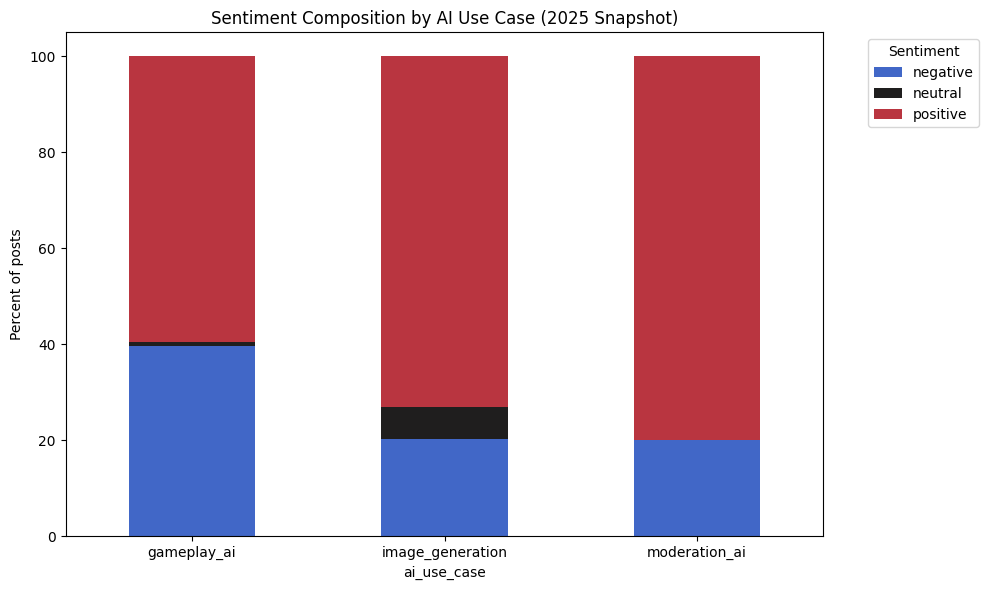

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generate a 3-color palette from cubehelix
# This gives distinct colors for Negative, Neutral, and Positive
colors = sns.color_palette("icefire", 3)

# --- Sentiment Composition by AI Use Case ---
sent_by_use = pd.crosstab(df_topic2["ai_use_case"], df_topic2["sentiment_label"], normalize="index") * 100

# Reorder columns to ensure logical flow
cols = ["negative", "neutral", "positive"]
sent_by_use = sent_by_use[cols] if set(cols).issubset(sent_by_use.columns) else sent_by_use

# 2. Pass the colors list to the plot function
sent_by_use.plot(kind="bar", stacked=True, color=colors, figsize=(10, 6))

plt.ylabel("Percent of posts")
plt.title("Sentiment Composition by AI Use Case (2025 Snapshot)")
plt.xticks(rotation=0)
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside
plt.tight_layout()
plt.show()

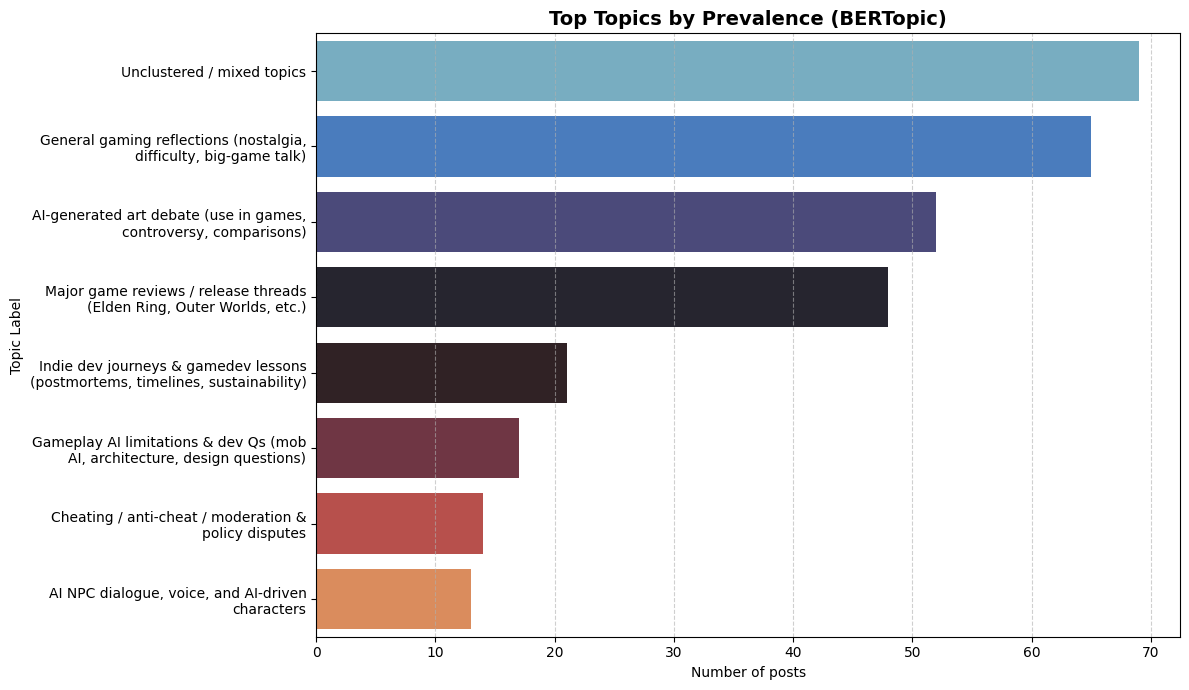

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap

# Get the top 8 topic counts
top_topic_counts = df_topic2["topic_label"].value_counts().head(8)

# Create the figure with a larger size for better readability
plt.figure(figsize=(12, 7))

# Use Seaborn's barplot with the 'cubehelix' palette for a professional look
sns.barplot(
    x=top_topic_counts.values,
    y=top_topic_counts.index,
    palette="icefire"
)

# Wrap long labels to make them readable
# The 'width' parameter controls how many characters before a new line
wrapped_labels = [ '\n'.join(wrap(label, width=40)) for label in top_topic_counts.index ]
plt.yticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels)

# Add titles and labels
plt.xlabel("Number of posts")
plt.ylabel("Topic Label")
plt.title("Top Topics by Prevalence (BERTopic)", fontsize=14, fontweight='bold')

# Add a subtle grid for easier reading of values
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Ensure everything fits nicely
plt.tight_layout()

# Show the plot
plt.show()

In [45]:
cols = ["ai_use_case", "topic_label", "sentiment_label", "compound",
        "score", "num_comments", "engagement", "title", "subreddit", "permalink"]

top_by_usecase = (
    df_topic2.sort_values("engagement", ascending=False)
    .groupby("ai_use_case")
    .head(5)[cols]
)

display(top_by_usecase)


,ai_use_case,topic_label,sentiment_label,compound,score,num_comments,engagement,title,subreddit,permalink
14,image_generation,Unclustered / mixed topics,positive,0.8622,31575.0,2417.0,36409.0,"Call of Duty: Black Ops 7 is littered with AI art slop, because your $70 means nothing anymore",gaming,https://www.reddit.com/r/gaming/comments/1owxnoi/call_of_duty_black_ops_7_is_littered_with_ai_art/
0,image_generation,"AI-generated art debate (use in games, controversy, comparisons)",negative,-0.6036,19563.0,1248.0,22059.0,Multi billion dollar company EA selling AI generated slop in their store (Battlefield 6),gaming,https://www.reddit.com/r/gaming/comments/1pt4ihv/multi_billion_dollar_company_ea_selling_ai/
23,image_generation,"AI-generated art debate (use in games, controversy, comparisons)",positive,0.7106,16254.0,2411.0,21076.0,"Larian Studios CEO Swen Vincke responds to GenAI criticism: ""Holy fuck guys we’re not ""pushing hard"" for or replacing concept artists with AI. I was asked explicitly about concept art and our use of Gen AI. I answered that we use it to explore things. I didn’t say we use it to develop concept art.""",gaming,https://www.reddit.com/r/gaming/comments/1pobzub/larian_studios_ceo_swen_vincke_responds_to_genai/
287,moderation_ai,Unclustered / mixed topics,positive,0.1270,11448.0,2563.0,16574.0,Games that 'cheated' to feel more fun,gaming,https://www.reddit.com/r/gaming/comments/1ihrx18/games_that_cheated_to_feel_more_fun/
1,image_generation,"AI-generated art debate (use in games, controversy, comparisons)",positive,0.9959,7626.0,2040.0,11706.0,Official Statement from the Indie Game Awards: 'Clair Obscur: Expedition 33' and 'Chantey's' awards retracted and awarded instead to 'Sorry We’re Closed' and 'Blue Prince' due to GenAI usage,gaming,https://www.reddit.com/r/gaming/comments/1prottw/official_statement_from_the_indie_game_awards/
5,image_generation,Unclustered / mixed topics,positive,0.9621,7575.0,1185.0,9945.0,"Divinity is confirmed to be turn based, planning to do early access again and Swen comments on Larian's use of AI- Bloomberg",gaming,https://www.reddit.com/r/gaming/comments/1po3zuw/divinity_is_confirmed_to_be_turn_based_planning/
199,gameplay_ai,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",positive,0.9997,1353.0,1254.0,3861.0,The Outer Worlds 2 Review Thread,Games,https://www.reddit.com/r/Games/comments/1oe2n8t/the_outer_worlds_2_review_thread/
201,gameplay_ai,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",positive,0.9997,1446.0,945.0,3336.0,Ghost of Yotei Review Thread,Games,https://www.reddit.com/r/Games/comments/1nq64yz/ghost_of_yotei_review_thread/
192,gameplay_ai,"General gaming reflections (nostalgia, difficulty, big-game talk)",positive,0.9987,2621.0,183.0,2987.0,Gabe Newell gets interviewed by seemingly small YouTuber,gaming,https://www.reddit.com/r/gaming/comments/1meq8nh/gabe_newell_gets_interviewed_by_seemingly_small/
178,gameplay_ai,Unclustered / mixed topics,negative,-0.9425,2221.0,350.0,2921.0,Death Stranding 2 was made easier to avoid players dropping out like in the first game,gaming,https://www.reddit.com/r/gaming/comments/1pp66lc/death_stranding_2_was_made_easier_to_avoid/


In [46]:
most_negative_by_usecase = (
    df_topic2.sort_values("compound", ascending=True)
    .groupby("ai_use_case")
    .head(5)[cols]
)

display(most_negative_by_usecase)


,ai_use_case,topic_label,sentiment_label,compound,score,num_comments,engagement,title,subreddit,permalink
146,image_generation,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",negative,-0.9993,0.0,12.0,24.0,15 questions for game devs.,gamedev,https://www.reddit.com/r/gamedev/comments/1lmhywq/15_questions_for_game_devs/
237,gameplay_ai,Cheating / anti-cheat / moderation & policy disputes,negative,-0.9977,0.0,64.0,128.0,[COD] The game being 17+ does not mean you can say anything over voice/text,CallOfDuty,https://www.reddit.com/r/CallOfDuty/comments/1i7ps6g/cod_the_game_being_17_does_not_mean_you_can_say/
166,image_generation,"General gaming reflections (nostalgia, difficulty, big-game talk)",negative,-0.9973,0.0,33.0,66.0,The deeper crisis behind the Steam Machine's 8GBs of VRAM,truegaming,https://www.reddit.com/r/truegaming/comments/1p48ts0/the_deeper_crisis_behind_the_steam_machines_8gbs/
184,gameplay_ai,Unclustered / mixed topics,negative,-0.9969,0.0,23.0,46.0,Spiderman 2 vs Arkham Knight,gaming,https://www.reddit.com/r/gaming/comments/1imso2d/spiderman_2_vs_arkham_knight/
121,image_generation,Cheating / anti-cheat / moderation & policy disputes,negative,-0.9959,76.0,16.0,108.0,randgrid.sys deployed a Tactical Nuke - wiped our squad before the game even started.,Warzone,https://www.reddit.com/r/Warzone/comments/1l6ymb5/randgridsys_deployed_a_tactical_nuke_wiped_our/
165,image_generation,"General gaming reflections (nostalgia, difficulty, big-game talk)",negative,-0.9949,902.0,203.0,1308.0,Why Is Game Optimization Getting Worse?,truegaming,https://www.reddit.com/r/truegaming/comments/1p9wctv/why_is_game_optimization_getting_worse/
296,moderation_ai,Unclustered / mixed topics,negative,-0.9948,127.0,8.0,143.0,Applied statistical methods to our analytics data for the first time the other day. Results were amazing!,gamedev,https://www.reddit.com/r/gamedev/comments/1k70c30/applied_statistical_methods_to_our_analytics_data/
185,gameplay_ai,Unclustered / mixed topics,negative,-0.9938,0.0,23.0,46.0,(Spoilers) I am extremely disappointed in the poor design and lack of polish of Jedi: Survivor,gaming,https://www.reddit.com/r/gaming/comments/1iewni8/spoilers_i_am_extremely_disappointed_in_the_poor/
274,gameplay_ai,"Major game reviews / release threads (Elden Ring, Outer Worlds, etc.)",negative,-0.9920,42.0,34.0,110.0,Why do so many Metroidvanias have a spooky slant?,truegaming,https://www.reddit.com/r/truegaming/comments/1ojotuq/why_do_so_many_metroidvanias_have_a_spooky_slant/
245,gameplay_ai,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",negative,-0.9887,1.0,5.0,11.0,Need Help With Enemy Ai Decision Making,gamedev,https://www.reddit.com/r/gamedev/comments/1pg6ac5/need_help_with_enemy_ai_decision_making/


In [47]:
negative_heavy_topics = [
    "Cheating / anti-cheat / moderation & policy disputes",
    "Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)"
]

neg_topic_examples = (
    df_topic2[df_topic2["topic_label"].isin(negative_heavy_topics)]
    .sort_values("compound", ascending=True)
    .head(10)[cols]
)

display(neg_topic_examples)


,ai_use_case,topic_label,sentiment_label,compound,score,num_comments,engagement,title,subreddit,permalink
146,image_generation,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",negative,-0.9993,0.0,12.0,24.0,15 questions for game devs.,gamedev,https://www.reddit.com/r/gamedev/comments/1lmhywq/15_questions_for_game_devs/
237,gameplay_ai,Cheating / anti-cheat / moderation & policy disputes,negative,-0.9977,0.0,64.0,128.0,[COD] The game being 17+ does not mean you can say anything over voice/text,CallOfDuty,https://www.reddit.com/r/CallOfDuty/comments/1i7ps6g/cod_the_game_being_17_does_not_mean_you_can_say/
121,image_generation,Cheating / anti-cheat / moderation & policy disputes,negative,-0.9959,76.0,16.0,108.0,randgrid.sys deployed a Tactical Nuke - wiped our squad before the game even started.,Warzone,https://www.reddit.com/r/Warzone/comments/1l6ymb5/randgridsys_deployed_a_tactical_nuke_wiped_our/
245,gameplay_ai,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",negative,-0.9887,1.0,5.0,11.0,Need Help With Enemy Ai Decision Making,gamedev,https://www.reddit.com/r/gamedev/comments/1pg6ac5/need_help_with_enemy_ai_decision_making/
277,gameplay_ai,Cheating / anti-cheat / moderation & policy disputes,negative,-0.9855,0.0,42.0,84.0,Is there anything we can do to combat game companies and their apathy?,truegaming,https://www.reddit.com/r/truegaming/comments/1mv7lny/is_there_anything_we_can_do_to_combat_game/
288,moderation_ai,Cheating / anti-cheat / moderation & policy disputes,negative,-0.9807,1.0,1.0,3.0,[COD] Steam Deck Ban,CallOfDuty,https://www.reddit.com/r/CallOfDuty/comments/1keuvyj/cod_steam_deck_ban/
239,gameplay_ai,Cheating / anti-cheat / moderation & policy disputes,negative,-0.9672,11.0,42.0,95.0,Cheating Isn't a Problem,Warzone,https://www.reddit.com/r/Warzone/comments/1o1o6jr/cheating_isnt_a_problem/
249,gameplay_ai,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",negative,-0.9632,0.0,6.0,12.0,I've been trying to make an Enemy Ai system for multiple days and I cant even get the basics running,gamedev,https://www.reddit.com/r/gamedev/comments/1oiqvyb/ive_been_trying_to_make_an_enemy_ai_system_for/
115,image_generation,Cheating / anti-cheat / moderation & policy disputes,negative,-0.9194,28.0,11.0,50.0,A Tribute to Maverick - A Lost Combatant,Warzone,https://www.reddit.com/r/Warzone/comments/1k0d6w0/a_tribute_to_maverick_a_lost_combatant/
250,gameplay_ai,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",negative,-0.8930,4.0,16.0,36.0,Not sure how to implement ai decision-making logic?,gamedev,https://www.reddit.com/r/gamedev/comments/1ob7ry6/not_sure_how_to_implement_ai_decisionmaking_logic/


In [48]:
from pathlib import Path

out_dir = Path("/content/outputs")
out_dir.mkdir(parents=True, exist_ok=True)

usecase_summary.to_csv(out_dir / "step12_usecase_summary.csv", index=False)
topic_summary.to_csv(out_dir / "step12_topic_summary.csv", index=False)
top_by_usecase.to_csv(out_dir / "step12_top_posts_by_usecase.csv", index=False)
most_negative_by_usecase.to_csv(out_dir / "step12_most_negative_by_usecase.csv", index=False)
neg_topic_examples.to_csv(out_dir / "step12_negative_topic_examples.csv", index=False)

print("Saved Step 12 outputs to:", out_dir)


Saved Step 12 outputs to: /content/outputs


In [49]:
# ==============================================================================
# RQ5: Most Used AI Use-Cases in Each Game Genre
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1) GENRE MAPPING — BASED ON GAME (NOT subreddit)
# ------------------------------------------------------------------------------
game_genre_map = {
    # Shooters
    "Call of Duty": "Shooter",
    "Warzone": "Shooter",
    "Battlefield": "Shooter",
    "Valorant": "Shooter",
    "Overwatch": "Shooter",
    "Apex Legends": "Shooter",

    # RPG
    "Elden Ring": "RPG",
    "Skyrim": "RPG",
    "Genshin Impact": "RPG",
    "Final Fantasy XIV": "RPG",
    "Monster Hunter": "RPG",

    # Action-Adventure
    "Assassin's Creed": "Action-Adventure",
    "Kingdom Come": "Action-Adventure",

    # Sandbox
    "Minecraft": "Sandbox",
    "The Sims": "Sandbox",
    "Sims 4": "Sandbox",

    # Strategy
    "Civilization": "Strategy",
    "Stellaris": "Strategy",
    "Total War": "Strategy",
    "XCOM": "Strategy",

    # MOBA
    "League of Legends": "MOBA",
    "Dota 2": "MOBA"
}

df_analysis["Genre"] = df_analysis["game"].map(game_genre_map)

# Drop unmapped games
df_genres = df_analysis.dropna(subset=["Genre", "ai_use_case"])

print("Genres kept:")
print(df_genres["Genre"].value_counts())


Genres kept:
Genre
Shooter             75
Strategy             7
Action-Adventure     5
MOBA                 5
RPG                  3
Sandbox              3
Name: count, dtype: int64


In [50]:
TOP_N = 10

counts = (
    df_genres
    .groupby(["Genre", "ai_use_case"])
    .size()
    .reset_index(name="freq")
)

top_counts = (
    counts
    .sort_values(["Genre", "freq"], ascending=[True, False])
    .groupby("Genre")
    .head(TOP_N)
)


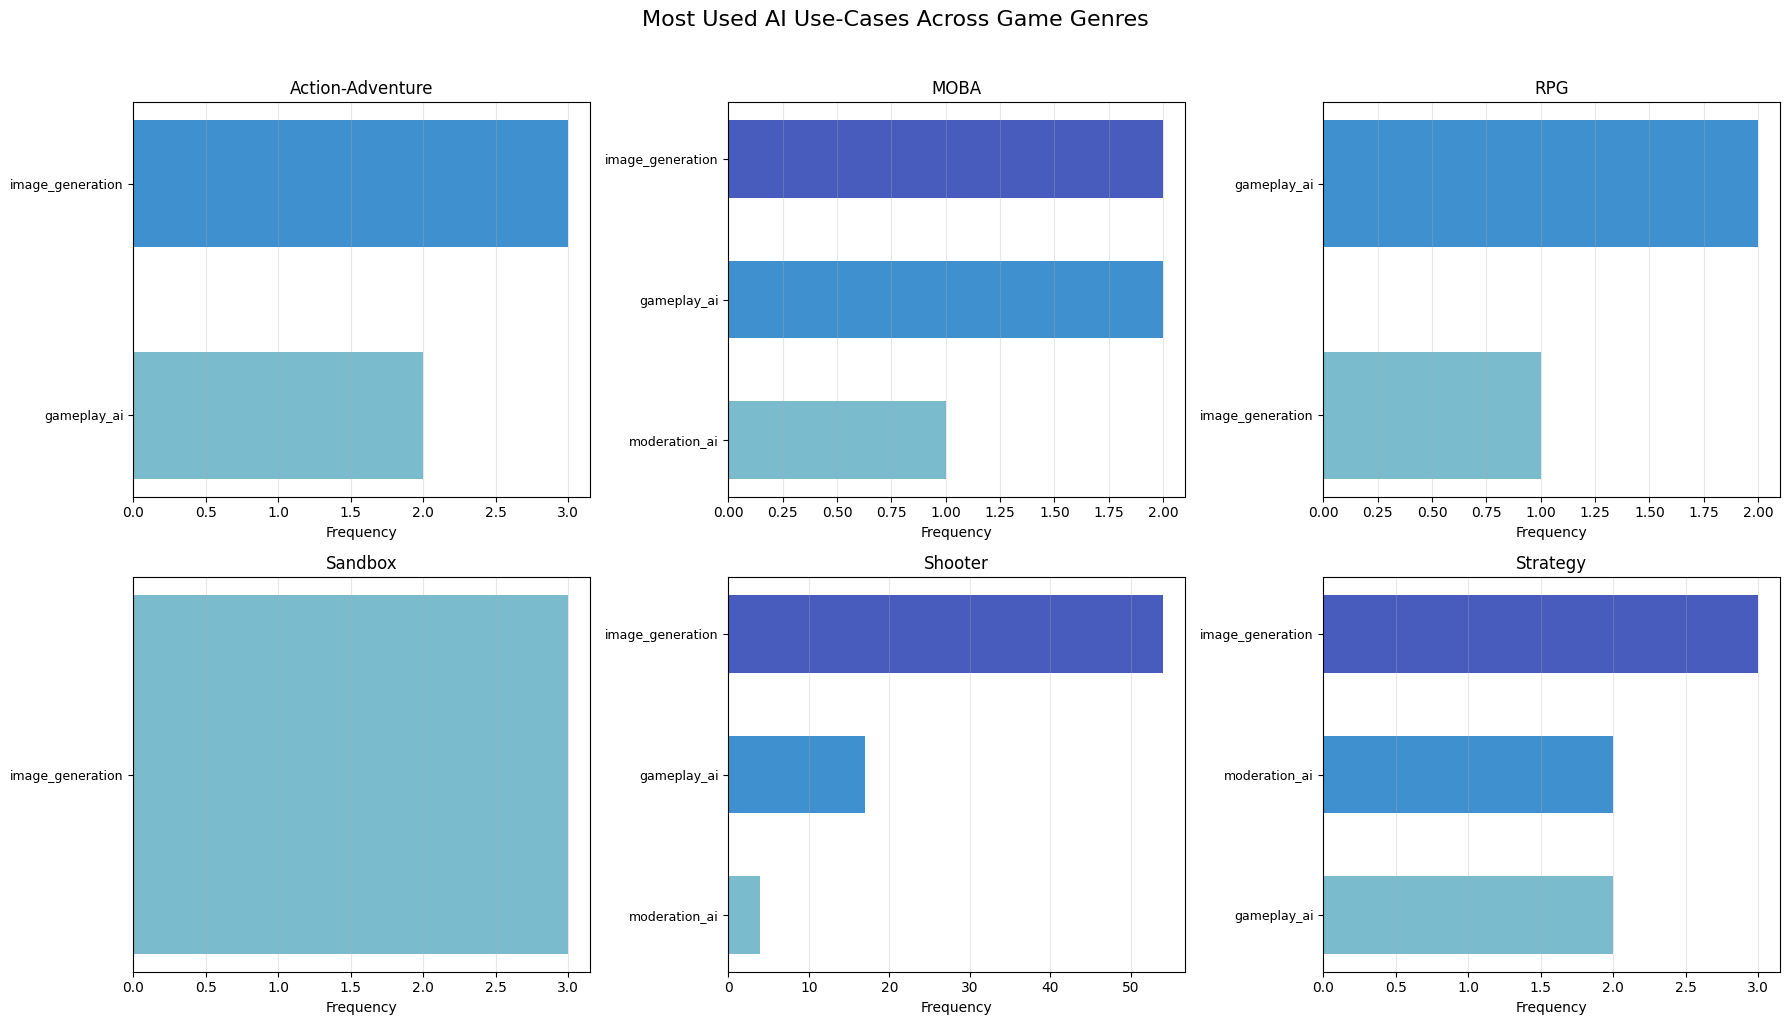

In [51]:
# ------------------------------------------------------------------------------
# 3) Plot — Same comparison, improved aesthetics
# ------------------------------------------------------------------------------

import seaborn as sns

genres = top_counts["Genre"].unique()
n_genres = len(genres)

ncols = 3
nrows = int(np.ceil(n_genres / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
axes = axes.flatten()

palette = sns.color_palette("icefire", n_colors=TOP_N)

for i, genre in enumerate(genres):
    ax = axes[i]

    data = (
        top_counts[top_counts["Genre"] == genre]
        .sort_values("freq", ascending=True)
        .reset_index(drop=True)
    )

    # Use color gradient within each genre
    colors = palette[:len(data)]

    ax.barh(
        y=data["ai_use_case"],
        width=data["freq"],
        color=colors,
        height=0.55   # 👈 thinner bars
    )

    ax.set_title(genre, fontsize=12)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("")
    ax.grid(axis="x", alpha=0.3)
    ax.tick_params(axis="y", labelsize=9)

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle(
    "Most Used AI Use-Cases Across Game Genres",
    fontsize=16,
    y=1.02
)

plt.tight_layout()
plt.show()


# **Conclusion**

In [52]:
# Key numbers for a thesis-ready summary (auto-pulled)
total_posts = len(df_analysis)

usecase_counts = df_analysis["ai_use_case"].value_counts()
usecase_pct = (usecase_counts / total_posts * 100).round(1)

topic_counts = df_topic2["topic_label"].value_counts()
topic_pct = (topic_counts / len(df_topic2) * 100).round(1)

print("=== Key Findings Summary (copy/paste) ===\n")
print(f"Dataset: {total_posts} Reddit posts (2025 snapshot).")
print("\nAI use case distribution:")
for uc in usecase_counts.index:
    print(f"- {uc}: {usecase_counts[uc]} posts ({usecase_pct[uc]}%)")

print("\nTop topics (BERTopic):")
for t in topic_counts.head(5).index:
    print(f"- {t}: {topic_counts[t]} posts ({topic_pct[t]}%)")

print("\nSentiment by use case (from Step 12):")
display(usecase_summary[["ai_use_case", "n_posts", "pos_%", "neg_%", "neu_%", "median_sentiment_compound"]])

print("\nEngagement by use case (from Step 12):")
display(usecase_summary[["ai_use_case", "median_engagement", "mean_engagement"]])

print("\nMost negative-heavy topics (from topic_summary):")
display(topic_summary.sort_values("neg_%", ascending=False)[["topic_label", "n_posts", "neg_%", "pos_%", "median_engagement"]].head(3))


=== Key Findings Summary (copy/paste) ===

Dataset: 299 Reddit posts (2025 snapshot).

AI use case distribution:
- image_generation: 178 posts (59.5%)
- gameplay_ai: 106 posts (35.5%)
- moderation_ai: 15 posts (5.0%)

Top topics (BERTopic):
- Unclustered / mixed topics: 69 posts (23.1%)
- General gaming reflections (nostalgia, difficulty, big-game talk): 65 posts (21.7%)
- AI-generated art debate (use in games, controversy, comparisons): 52 posts (17.4%)
- Major game reviews / release threads (Elden Ring, Outer Worlds, etc.): 48 posts (16.1%)
- Indie dev journeys & gamedev lessons (postmortems, timelines, sustainability): 21 posts (7.0%)

Sentiment by use case (from Step 12):


,ai_use_case,n_posts,pos_%,neg_%,neu_%,median_sentiment_compound
1,image_generation,178,73.033708,20.224719,6.741573,0.94500
0,gameplay_ai,106,59.433962,39.622642,0.943396,0.77895
2,moderation_ai,15,80.000000,20.000000,0.000000,0.92830



Engagement by use case (from Step 12):


,ai_use_case,median_engagement,mean_engagement
1,image_generation,95.0,1327.780899
0,gameplay_ai,59.0,384.669811
2,moderation_ai,143.0,1529.466667



Most negative-heavy topics (from topic_summary):


,topic_label,n_posts,neg_%,pos_%,median_engagement
2,Cheating / anti-cheat / moderation & policy disputes,14,64.285714,28.571429,82.0
3,"Gameplay AI limitations & dev Qs (mob AI, architecture, design questions)",17,58.823529,41.176471,24.0
4,"General gaming reflections (nostalgia, difficulty, big-game talk)",65,27.692308,69.230769,64.0
